In [1]:
import sys
import math
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import random
import numpy as np
import cvxopt
import pypoman
import time
from numpy.testing import assert_allclose
from iteround import saferound
from welford import Welford
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
   intersection_mart, plot_marts_eta, construct_exhaustive_eta_grid, construct_eta_bands, brute_force_uits, selector,\
   construct_eta_grid_plurcomp, construct_vertex_etas, simulate_plurcomp, construct_eta_bands_plurcomp, random_truncated_gaussian,\
   PGD, convex_uits, stratified_t_test, banded_uits, generate_oneaudit_population, generate_hybrid_audit_population, construct_eta_bands_hybrid
np.random.seed(1337)

### Universal portfolio vs grid-kelly: computation time and wealth

In [100]:
eta_0 = 1/2
pop = np.append(np.random.normal(eta_0 + 0.1, 0.2, 100), np.ones(100) * 0.6)
X = np.random.choice(pop, len(pop), replace = False)

In [101]:
%%time
m_ko = mart(X, eta = eta_0, lam_func = Bets.kelly_optimal, N = np.inf, log = True)

CPU times: user 1.44 ms, sys: 19 μs, total: 1.46 ms
Wall time: 1.46 ms


In [102]:
%%time
#universal portfolio
m_up = mart(X, eta = eta_0, lam_func = Bets.universal_portfolio, N = np.inf, log = True)

CPU times: user 16.6 s, sys: 428 ms, total: 17 s
Wall time: 16.8 s


In [103]:
%%time
# grid kelly
bets = [(lambda x, eta, c=b: Bets.fixed(x, eta, c = c)) for b in np.linspace(0.05, 1/eta_0-0.05, 100)]
m_gk = mart(X, eta = eta_0, lam_func = bets, N = np.inf, log = True)

CPU times: user 5.49 ms, sys: 285 μs, total: 5.77 ms
Wall time: 5.52 ms


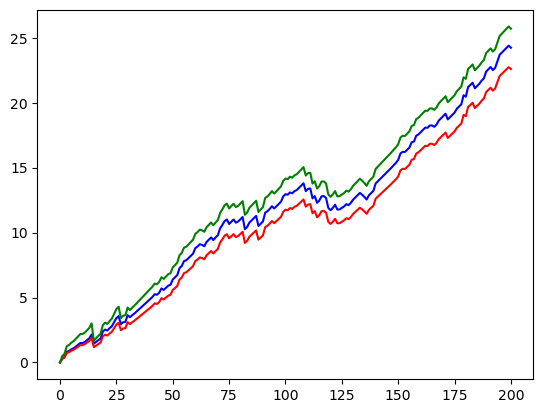

In [106]:
plt.plot(m_up, color = 'blue')
plt.plot(m_gk, color = 'red')
plt.plot(m_ko, color = 'green')
plt.show()

### Universal portfolio and Kelly-optimal bets

In [34]:
x = np.random.normal(0.52, 0.15, 1000)
eta_0 = 1/2

In [35]:
%%time
ko_bets = Bets.kelly_optimal(x, eta_0)

CPU times: user 2.21 ms, sys: 3.68 ms, total: 5.89 ms
Wall time: 9.96 ms


In [36]:
%%time
up_bets = Bets.universal_portfolio(x, eta_0, step = 10)

CPU times: user 12.4 s, sys: 271 ms, total: 12.7 s
Wall time: 12.8 s


In [37]:
%%time 
agrapa_bets = Bets.agrapa(x, eta_0, c = 1)

CPU times: user 11.5 ms, sys: 1.53 ms, total: 13.1 ms
Wall time: 13.6 ms


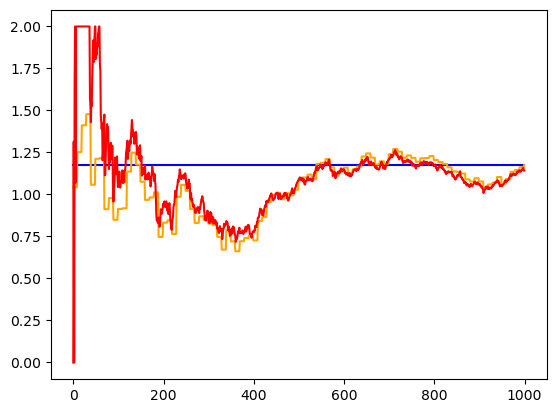

In [38]:
plt.plot(ko_bets, color = 'blue')
plt.plot(up_bets, color = 'orange')
plt.plot(agrapa_bets, color = 'red')
plt.show()

### ONE assorter population versus STS hybrid audit population and corresponding TSMs

In [27]:
# parameters
A_c_bar = 0.55 # overall mean
delta_across = 0.5 # spread between noCVR and CVR stratum
delta_within = 0.2 # spread between batches within noCVR stratum
num_batches = 10 # number of batches in noCVR stratum
batch_size = 1000 # size of each batch in noCVR stratum
prop_invalid = 0.0 # proportion of invalid votes in both strata (evenly distributed across batches)
num_cvrs = 10000 # size of CVR stratum
alpha = 0.05 # risk limit
u = 1 # upper bound for plurality assorters

In [28]:
%time
# construct ONEAudit population, shuffle, and compute the TSM
# expand parameters for batches
A_c_bar_batches = A_c_bar - 0.5 * delta_across # overall batch mean
A_c_batches = np.linspace(
    A_c_bar_batches - 0.5 * delta_within,
    A_c_bar_batches + 0.5 * delta_within,
    num_batches)
batch_sizes = np.ones(num_batches) * batch_size
invalids = np.ones(num_batches) * prop_invalid
# expand parameters for CVRs
prop_invalid_cvrs = prop_invalid
A_c_bar_cvrs = A_c_bar + 0.5 * delta_across
cvrs_i = num_cvrs * prop_invalid_cvrs # the number of CVRs showing invalid votes
cvrs_w = num_cvrs * A_c_bar_cvrs * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_l = num_cvrs * (1 - A_c_bar_cvrs) * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_iwl = [int(c) for c in saferound([cvrs_i, cvrs_w, cvrs_l], places = 0)] # rounding to integers
A_c_cvrs = np.repeat([1/2, 1, 0], cvrs_iwl)
# combine
A_c = np.append(A_c_batches, A_c_cvrs)
batch_sizes = np.append(batch_sizes, np.ones(num_cvrs))
invalids = np.append(invalids, np.append(np.ones(cvrs_iwl[0]), np.zeros(cvrs_iwl[1] + cvrs_iwl[2])))
# construct ONE assorter population
N = np.sum(batch_sizes) # the size of the population/sample
assorter_pop_unscaled = generate_oneaudit_population(
        batch_sizes = batch_sizes,
        A_c = A_c,
        invalid = invalids
    )
eta_0_unscaled = 1/2 # global null mean
realized_A_c_bar = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means (may differ slightly from intended mean A_c_bar)
v_bar = 2 * realized_A_c_bar - 1 # global margin
# assorters and global null are rescaled to [0,1]
ONE_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_bar))
ONE_eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_bar))

X = np.random.permutation(ONE_pop)
tsm = mart(X, eta = ONE_eta_0, lam_func = Bets.kelly_optimal, N = N, log = True)

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 12.2 μs


/Users/Jake/opt/anaconda3/envs/strat/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


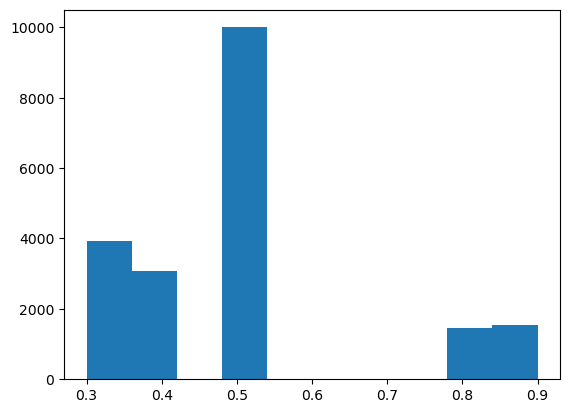

In [29]:
# histogram of population encoded as ONEAudit assorters
plt.hist(ONE_pop)
plt.show()

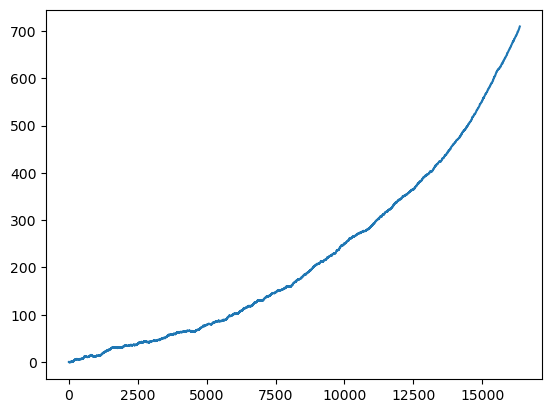

In [30]:
# TSM over time
plt.plot(tsm)
plt.show()

In [32]:
%%time
# stratified audit using sweeter-than-SUITE
strata = np.repeat(np.where(batch_sizes > 1, 0, 1), repeats = batch_sizes.astype("int")) # place ballots with CVRs (batch_size == 1) into stratum 1, and larger batches into stratum 0
K = 2 # the number of strata
N_strat = np.unique(strata, return_counts = True)[1] # the size of the population in each stratum
A_c_strat = [A_c_bar_batches, A_c_bar_cvrs]
prop_invalid_strat = [prop_invalid, prop_invalid_cvrs]
STS_pop = generate_hybrid_audit_population(N_strat, A_c_strat, prop_invalid_strat, assort_method = "STS")
STS_etas = construct_eta_bands_hybrid(A_c_strat, N_strat, n_bands = 100, assort_method = "STS")

X = []
for k in range(K):
    X.append(np.random.permutation(STS_pop[k]))
uits = banded_uits(X,
                N = N_strat,
                etas = STS_etas,
                lam_func = Bets.kelly_optimal,
                allocation_func = Allocations.proportional_round_robin,
                log = True,
                WOR = False,
                verbose = True)

CPU times: user 39 s, sys: 324 ms, total: 39.3 s
Wall time: 39.3 s


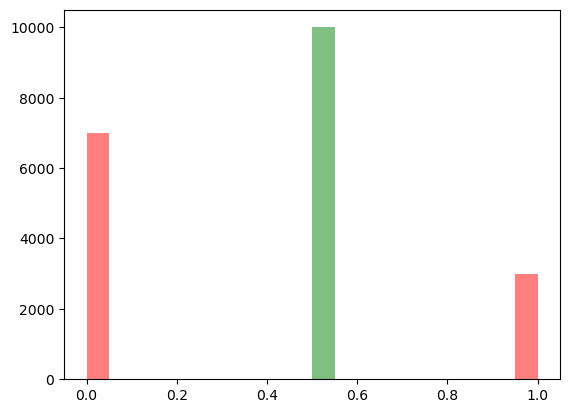

In [33]:
# histogram of STS population
colors = ['red', 'green']
for i, array in enumerate(STS_pop):
    plt.hist(array, bins=20, color=colors[i], alpha=0.5, label=f'Array {i+1}')
plt.show()

[0.4 0.5 0.9]


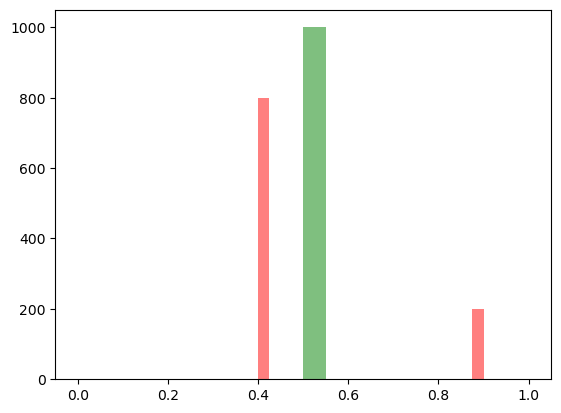

In [30]:
N_strat = [1000, 1000]
A_c_strat = [0.2, 0.9]
assorter_pop = generate_hybrid_audit_population(N_strat, A_c_strat, prop_invalid_strat, assort_method = "STS")
etas = construct_eta_bands_hybrid(A_c_strat, N_strat, n_bands = 100, assort_method = "STS")
X = []
for k in range(K):
    X.append(np.random.permutation(assorter_pop[k]))
m_sts = banded_uits(X, N = N_strat, etas = etas, lam_func = Bets.kelly_optimal, allocation_func = Allocations.proportional_round_robin, log = True)[0]
# plot population
print(np.unique(assorter_pop))
colors = ['red', 'green']
for i, array in enumerate(assorter_pop):
    plt.hist(array, bins=20, color=colors[i], alpha=0.5, label=f'Array {i+1}')
plt.show()

[0.42105263 0.52631579 0.94736842]


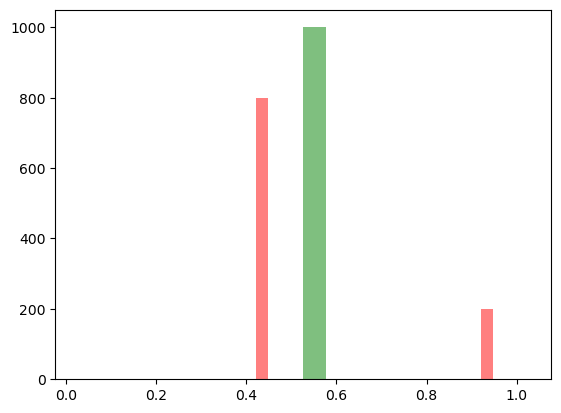

In [29]:
assorter_pop = generate_hybrid_audit_population(N_strat, A_c_strat, prop_invalid_strat, assort_method = "ONE")
etas = construct_eta_bands_hybrid(A_c_strat, N_strat, n_bands = 100, assort_method = "ONE")
X = []
for k in range(K):
    X.append(np.random.permutation(assorter_pop[k]))
m_one = banded_uits(X, N = N_strat, etas = etas, lam_func = Bets.kelly_optimal, allocation_func = Allocations.proportional_round_robin, log = True)[0]
#plot population
print(np.unique(assorter_pop))
colors = ['red', 'green']
for i, array in enumerate(assorter_pop):
    plt.hist(array, bins=20, color=colors[i], alpha=0.5, label=f'Array {i+1}')
plt.show()

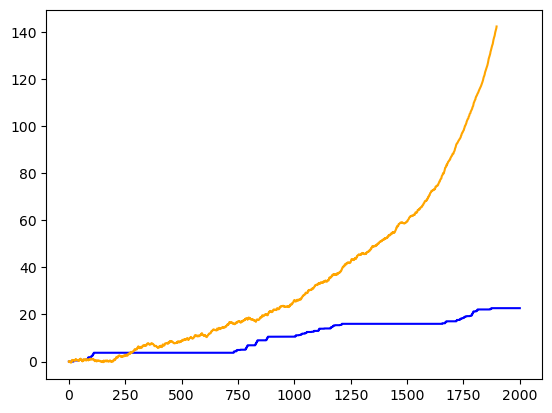

In [8]:
# plot of UITS and tsm over time
plt.plot(uits[0], color = 'blue')
plt.plot(tsm, color = 'orange')
plt.show()

In [72]:
%time 
#A_c_bar_grid = np.linspace(0.51, 0.75, 5) # global assorter means
A_c_bar_grid = [0.51] # these are the attempted global margins, the actual global margin may differ slightly because of integer rounding of votes
delta_across_grid = [0.5] # controls the spread between the mean for CVRs and the mean for batches
delta_within_grid = [0.0] # controls the spread between batches
polarized_grid = [False] # whether or not there is polarization (uniform or clustered batch totals)
num_batch_ballots = 10000
batch_size_grid = [1000, 10000] # assuming for now, equally sized batches
ratio_cvrs_grid = [1] # the ratio of the size of the CVR stratum to the batches
prop_invalid_grid = [0.1] # proportion of invalid votes in each batch (uniform across batches)
alpha = 0.05 # risk limit
rep_grid = np.arange(1)
n_reps = len(rep_grid)


n_next = 500 #size of blocks at which sample will expand
n_max = 1500 # maximum size of sample, at which point the simulation will terminate


bets_dict = {
    "cobra": "special handling",
    "agrapa": lambda x, eta: Bets.agrapa(x, eta, c = 0.99),
    "alpha": "special handling", # see below
    "kelly-optimal": "special handling",
    "universal-portfolio": lambda x, eta: Bets.universal_portfolio(x, eta, step = 50)
    }
bets_grid = list(bets_dict.keys())

results = []
i = 0

for A_c_bar, delta_within, delta_across, prop_invalid, bet, ratio_cvrs, batch_size, polarized in itertools.product(A_c_bar_grid, delta_within_grid, delta_across_grid, prop_invalid_grid, bets_grid, ratio_cvrs_grid, batch_size_grid, polarized_grid):
    i += 1
    print(f'A_c: {A_c_bar}, delta_w: {delta_within}, delta_a: {delta_across}, prop_invalid: {prop_invalid}, bet: {bet}, ratio_cvrs: {ratio_cvrs}, batch_size: {batch_size}, polarized: {polarized}')
    u = 1 # upper bound for plurality assorters
    assert (num_batch_ballots % batch_size) == 0, "number of batch ballots is not divisible by the number of batches"
    num_batches = int(num_batch_ballots / batch_size)
    num_cvrs = int(np.round(ratio_cvrs * num_batch_ballots))
    N = num_batch_ballots + num_cvrs # population size
    prop_cvrs = num_cvrs / N # proportion of votes that are CVRs
    prop_batches = 1 - prop_cvrs # proportion of votes that are in batches

    # means and sizes for batches
    # A_c_bar = prop_batches * A_c_bar_batches + prop_cvrs * A_c_bar_cvrs
    A_c_bar_batches = A_c_bar - 0.5 * delta_across # overall batch mean
    if num_batches == 1:
        if polarized:
            continue
        else:
            A_c_batches = A_c_bar_batches
    elif polarized:
        if delta_within == 0:
            continue
        assert (num_batches % 2) == 0, "number of batches must be divisible by two to maintain bar mean with polarization"
        A_c_batches = np.append(
            (A_c_bar_batches - 0.5 * delta_within) * np.ones(int(num_batches/2)),
            (A_c_bar_batches + 0.5 * delta_within) * np.ones(int(num_batches/2))
        )
    else:
        A_c_batches = np.linspace(
            A_c_bar_batches - 0.5 * delta_within,
            A_c_bar_batches + 0.5 * delta_within,
            num_batches)
    batch_sizes = np.ones(num_batches) * batch_size
    invalids = np.ones(num_batches) * prop_invalid


    # make CVRs
    prop_invalid_cvrs = prop_invalid
    A_c_bar_cvrs = A_c_bar + 0.5 * delta_across
    # this logic makes the CVR mean for _valid_ votes equal to A_c_bar_cvrs; not for all votes
    cvrs_i = num_cvrs * prop_invalid_cvrs # the number of CVRs showing invalid votes
    cvrs_w = num_cvrs * (A_c_bar_cvrs - prop_invalid_cvrs/2) # the number of CVRs showing votes for the winner
    cvrs_l = num_cvrs * (1 - A_c_bar_cvrs - prop_invalid_cvrs/2) # the number of CVRs showing votes for the loser
    cvrs_iwl = [int(c) for c in saferound([cvrs_i, cvrs_w, cvrs_l], places = 0)] # rounding to integers
    A_c_cvrs = np.repeat([1/2, 1, 0], cvrs_iwl)

    # add CVRs
    A_c = np.append(A_c_batches, A_c_cvrs)
    batch_sizes = np.append(batch_sizes, np.ones(num_cvrs))
    invalids = np.append(invalids, np.append(np.ones(cvrs_iwl[0]), np.zeros(cvrs_iwl[1] + cvrs_iwl[2])))

    stopping_times = np.zeros(n_reps) # container for stopping times in each simulation
    run_times = np.zeros(n_reps) # container for run times in each simulation

    # create population of ONEAudit assorters
    assorter_pop_unscaled = generate_oneaudit_population(
            batch_sizes = batch_sizes,
            A_c = A_c,
            invalid = invalids
        )
    eta_0_unscaled = 1/2 # global null mean

    realized_A_c_bar = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means
    v_bar = 2 * realized_A_c_bar - 1 # global margin

    # assorters and global null are rescaled to [0,1]
    assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_bar))
    eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_bar))



    #derive kelly-optimal bet one time by applying numerical optimization to entire population
    if bet == "alpha":
        # alpha (predictable bernoulli) get shrunk towards the true mean of the population
        bets_dict["alpha"] = lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.99, mu_0 = np.mean(assorter_pop))
    if bet == "kelly-optimal":
        ko_bet = Bets.kelly_optimal(assorter_pop, eta_0)
    if bet == "cobra":
        bets_dict["cobra"] = lambda x, eta: Bets.cobra(x, eta, A_c = A_c_bar)

    for r in rep_grid:
        # containers for expanding samples
        selected = np.array([], dtype = np.int32) # the index of samples that have been selected
        remaining = np.arange(N) # the index of values remaining the population
        done = False
        start_time = time.time()
        while not done:
            selected = np.append(selected, np.random.choice(remaining, size = n_next, replace = False))
            remaining = np.setdiff1d(remaining, selected)
            X = assorter_pop[selected]
            # TSMs are computed for sampling WOR
            if bet == "kelly-optimal":
                m = mart(X, eta = eta_0, lam = ko_bet[0:len(X)], N = N, log = True)
            else:
                m = mart(X, eta = eta_0, lam_func = bets_dict[bet], N = N, log = True)
            if any(m > -np.log(alpha)) or (len(X) >= n_max):
                done = True
        stopping_time = np.where(any(m > -np.log(alpha)), np.argmax(m > -np.log(alpha)), n_max) # where the TSM crosses 1/alpha, or else the population size
        run_time = time.time() - start_time
        data_dict = {
            "A_c_bar":A_c_bar,
            "delta_within":delta_within,
            "delta_across":delta_across,
            "assort_method":"ONE",
            "polarized":polarized,
            "rep":r,
            "num_batches":num_batches,
            "num_cvrs":num_cvrs,
            "prop_cvrs":prop_cvrs,
            "batch_size":batch_size,
            "prop_invalid":prop_invalid,
            "bet":str(bet),
            "sample_size": stopping_time,
            "run_time":run_time}
        results.append(data_dict)
        print(f'run_time: {run_time}, rep: {r}, A_c: {A_c_bar}, delta_w: {delta_within}, delta_a: {delta_across}, prop_invalid: {prop_invalid}, bet: {bet}, ratio_cvrs: {ratio_cvrs}, batch_size: {batch_size}, polarized: {polarized}')


CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 4.77 μs
A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: cobra, ratio_cvrs: 1, batch_size: 1000, polarized: False
run_time: 0.004637002944946289, rep: 0, A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: cobra, ratio_cvrs: 1, batch_size: 1000, polarized: False
A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: cobra, ratio_cvrs: 1, batch_size: 10000, polarized: False
run_time: 0.004137992858886719, rep: 0, A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: cobra, ratio_cvrs: 1, batch_size: 10000, polarized: False
A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: agrapa, ratio_cvrs: 1, batch_size: 1000, polarized: False
run_time: 0.006132841110229492, rep: 0, A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: agrapa, ratio_cvrs: 1, batch_size: 1000, polarized: False
A_c: 0.51, delta_w: 0.0, delta_a: 0.5, prop_invalid: 0.1, bet: agrapa, ratio_cvrs: 1, batch_

np.float64(0.76)

In [43]:
K = 2
selected = [np.array([], dtype=np.int32), np.array([], dtype=np.int32)] # the index of samples that have been selected
remaining = [np.arange(N_strat[0], dtype=np.int32), np.arange(N_strat[1], dtype=np.int32)] # the index of values remaining the population
X = [np.array([]), np.array([])] # container for samples

n_next = 100

for k in range(K):
    selected[k] = np.append(selected[k], np.random.choice(remaining[k], size = n_next, replace = False))
    remaining[k] = np.setdiff1d(remaining[k], selected[k])
    X[k] = assorter_pop[k][selected[k]]

In [91]:
# some minimizing bands (represented by their centroid)
uits[1][250:260]

array([[0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975],
       [0.205 , 0.4975]])

In [93]:
STS_etas[20]

[(array([0.2, 0.5]), array([0.21 , 0.495])), array([0.205 , 0.4975])]

In [92]:
# the kelly bets at the minimizer
#NOTE: see lines  1166-1168 of utils.py; the bets are set _conservatively_ for each band
# however, the main issue is that in this band there is a null that makes it so no money can be gained in the low-variance stratum
# for this I-TSM, pulling from the comparison stratum is never advantageous
# it basically reduces to ballot-polling, except that every other sample is completely wasted. 
for k in range(2):
    print(uits[5][20][k][0])

0.5424954792044356
0.0


In [95]:
# stratified audit using sweeter-than-SUITE
strata = np.repeat(np.where(batch_sizes > 1, 0, 1), repeats = batch_sizes.astype("int")) # place ballots with CVRs (batch_size == 1) into stratum 1, and larger batches into stratum 0
K = 2 # the number of strata
N_strat = np.unique(strata, return_counts = True)[1] # the size of the population in each stratum
A_c_strat = [A_c_bar_batches, A_c_bar_cvrs]
prop_invalid_strat = [prop_invalid, prop_invalid_cvrs]
STS_pop = generate_hybrid_audit_population(N_strat, A_c_strat, invalid, assort_method = "STS")
STS_etas = construct_eta_bands_hybrid(A_c_strat, N_strat, n_bands = 100, assort_method = "STS")

X = []
for k in range(K):
    X.append(np.random.permutation(STS_pop[k]))
uits = banded_uits(X,
                N = N_strat,
                etas = STS_etas,
                lam_func = Bets.kelly_optimal,
                allocation_func = Allocations.predictable_kelly,
                log = True,
                WOR = False,
                verbose = True)

In [3]:
%%time
# dummy example with Gaussians with spread between means
eta_0 = 0.5
global_mean = 0.6
deltas = [-0.25, 0.25]
sd = 0.1
N = [100, 100]
n_reps = 30
K = 2
alpha = 0.05

stopping_times_u = np.zeros(n_reps)
stopping_times_s = np.zeros(n_reps)
for r in range(n_reps):
    X_strat = [random_truncated_gaussian(mean = global_mean + deltas[k], sd = sd, size = N[k]) for k in range(K)]
    X_unstrat = np.array([])
    for i in range(np.sum(N)):
        k_rand = np.random.choice([0,1], size = 1)[0]
        X_unstrat = np.append(X_unstrat, random_truncated_gaussian(mean = global_mean + deltas[k_rand], sd = sd, size = 1))
    
    #unstratified
    bets_u = mart(X_unstrat, eta = eta_0, lam_func = Bets.kelly_optimal, N = np.sum(N), log = True, output = "bets")
    m_u = mart(X_unstrat, eta = eta_0, lam_func = Bets.kelly_optimal, N = np.sum(N), log = True)
    stopping_times_u[r] = np.where(any(m_u > -np.log(alpha)), np.argmax(m_u > -np.log(alpha)), np.sum(N)) # where the TSM crosses 1/alpha, or else the population size
    
    #stratified
    etas_100 = construct_eta_bands(eta_0, N, n_bands = 100) # the null space, partitioned into bands
    uits = banded_uits(
        X_strat,
        N = N,
        etas = etas_100,
        lam_func = Bets.kelly_optimal,
        allocation_func = Allocations.proportional_round_robin,
        log = True,
        WOR = True,
        verbose = True)
    m_s = uits[0]
    stopping_times_s[r] = np.where(any(m_s > -np.log(alpha)), np.argmax(m_s > -np.log(alpha)), np.sum(N)) # where the TSM crosses 1/alpha, or else the population size

print(f"stopping time unstratified:{np.round(np.mean(stopping_times_u))}\nstopping_time_stratified:{np.round(np.mean(stopping_times_s))}\n")

stopping time unstratified:35.0
stopping_time_stratified:29.0

CPU times: user 12.9 s, sys: 106 ms, total: 13.1 s
Wall time: 13.1 s


In [19]:
%%time
np.random.seed(1337)
# dummy example with Gaussians with low and high variance
eta_0 = 0.5
global_mean = 0.6
sds = [0.2, 0.01]
N = [100, 100]
n_reps = 100

stopping_times_u = np.zeros(n_reps)
stopping_times_s = np.zeros(n_reps)
stopping_times_n = np.zeros(n_reps)
stopping_times_glcb = np.zeros(n_reps)
stopping_times_glcb_neyman = np.zeros(n_reps)
for r in range(n_reps):
    X_strat = [random_truncated_gaussian(mean = global_mean, sd = sds[k], size = N[k]) for k in range(K)]
    X_unstrat = np.array([])
    for i in range(np.sum(N)):
        k_rand = np.random.choice([0,1], size = 1)[0]
        X_unstrat = np.append(X_unstrat, random_truncated_gaussian(mean = global_mean, sd = sds[k_rand], size = 1))
    
    # unstratified
    bets_u = mart(X_unstrat, eta = eta_0, lam_func = Bets.kelly_optimal, N = np.sum(N), log = True, output = "bets")
    m_u = mart(X_unstrat, eta = eta_0, lam_func = Bets.kelly_optimal, N = np.sum(N), log = True)
    stopping_times_u[r] = np.where(any(m_u > -np.log(alpha)), np.argmax(m_u > -np.log(alpha)), np.sum(N)) # where the TSM crosses 1/alpha, or else the population size
    
    # stratified + uits
    etas_100 = construct_eta_bands(eta_0, N, n_bands = 100) # the null space, partitioned into bands
    uits = banded_uits(
        X_strat,
        N = N,
        etas = etas_100,
        lam_func = Bets.kelly_optimal,
        allocation_func = Allocations.proportional_round_robin,
        log = True,
        WOR = True,
        verbose = True)
    m_s = uits[0]
    stopping_times_s[r] = np.where(any(m_s > -np.log(alpha)), np.argmax(m_s > -np.log(alpha)), np.sum(N))
    
    uits_neyman = banded_uits(
        X_strat,
        N = N,
        etas = etas_100,
        lam_func = Bets.kelly_optimal,
        allocation_func = Allocations.neyman,
        log = True,
        WOR = True,
        verbose = True)
    m_n = uits_neyman[0]
    stopping_times_n[r] = np.where(any(m_n > -np.log(alpha)), np.argmax(m_n > -np.log(alpha)), np.sum(N))

    # stratified + lcb
    glcb = global_lower_bound(
        X_strat,
        N,
        lam_func = Bets.kelly_optimal,
        allocation_func = Allocations.proportional_round_robin,
        alpha = 0.05,
        WOR = True
    )
    stopping_times_glcb[r] = np.where(any(glcb > eta_0), np.argmax(glcb > eta_0), np.sum(N))

    glcb_neyman = global_lower_bound(
        X_strat,
        N,
        lam_func = Bets.kelly_optimal,
        allocation_func = Allocations.neyman,
        alpha = 0.05,
        WOR = True
    )
    stopping_times_glcb_neyman[r] = np.where(any(glcb_neyman > eta_0), np.argmax(glcb_neyman > eta_0), np.sum(N))

print(f"stopping time unstratified:{np.round(np.mean(stopping_times_u))}\nstopping time uits proportional:{np.round(np.mean(stopping_times_s))}\nstopping time uits neyman:{np.round(np.mean(stopping_times_n))}\nstopping time glcb proportional:{np.round(np.mean(stopping_times_glcb))}\nstopping time glcb neyman:{np.round(np.mean(stopping_times_glcb_neyman))}\n")

stopping time unstratified:21.0
stopping time uits proportional:22.0
stopping time uits neyman:74.0
stopping time glcb proportional:37.0
stopping time glcb neyman:81.0

CPU times: user 2min 26s, sys: 1.94 s, total: 2min 28s
Wall time: 2min 32s


In [5]:
K = 3
N = [10,10,5]
x = [np.ones(N[0]) * 0.5, np.ones(N[1]) * 0.5, np.ones(N[2]) * 0.5]
eta = [0.3,0.5,0.5]
lam = None
lam_func = [[Bets.fixed, Bets.agrapa] for k in range(K)]
log = False
WOR = False
combine = 'product'


ws_log = False if combine == "sum" else log
ws_N = N if WOR else np.inf*np.ones(K)
if lam is None:
    lam = [mart(x[k], eta[k], lam_func[k], None, ws_N[k], ws_log, output = "bets") for k in np.arange(K)]
#within-stratum martingales
ws_marts = [mart(x[k], eta[k], None, lam[k], ws_N[k], ws_log) for k in np.arange(K)]

In [15]:
batch_sizes = np.array([3,1,1,1])
A_c = [1, 1,1,0]
invalid = None


A_c_global = np.dot(batch_sizes / np.sum(batch_sizes), A_c)
assert A_c_global > 1/2, "contradiction: batch-level assorter means imply reported winner lost"
B = len(batch_sizes) # the number of batches
if invalid is None:
    invalid = np.zeros(B)
u = 1 # the upper bound on the original assorters for plurality contests
batches = []

v = 2 * A_c_global - 1 # global reported assorter margin
for i in range(B):
    # these votes are possibly fractional and need to be rounded
    invalid_votes = batch_sizes[i] * invalid[i] # the number of invalid votes
    votes_for_winner = batch_sizes[i] * A_c[i] * (1 - invalid[i]) # the number of votes for the winner
    votes_for_loser = batch_sizes[i] * (1 - A_c[i]) * (1 - invalid[i]) # the number of votes for the loser
    # rounding while preserving the sum
    votes = saferound([invalid_votes, votes_for_winner, votes_for_loser], places = 0)
    votes = [int(vote) for vote in votes] # conversion to integers

    # ONE assorter values
    B_i = (u + 1/2 - A_c[i]) / (2 * u - v) # assorter for invalid votes
    B_w = (u + 1 - A_c[i]) / (2 * u - v) # assorter for winner votes
    B_l = (u + 0 - A_c[i]) / (2 * u - v) # assorter for loser votes

    # assorter populations as an array
    batches.append(np.concatenate([B_i * np.ones(votes[0]), B_w * np.ones(votes[1]), B_l * np.ones(votes[2])]))
pop = np.concatenate(batches)
pop

array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75])

In [13]:
K = 3
ws_mixture_bets = [Bets.fixed, Bets.agrapa]
bets = [ws_mixture_bets for k in range(K)]

In [6]:
N = [100, 100]
n = [100, 100]
eta_1 = [1,0]
eta_2 = [0,1]
samples = [0.6 * np.ones(n[0]), 0.6 * np.ones(n[1])]
bets = [Bets.fixed(samples[k], eta_1[k]) for k in np.arange(2)]
selections_1 = selector(samples, N, Allocations.predictable_kelly, eta_1, bets)
selections_2 = selector(samples, N, Allocations.predictable_kelly, eta_2, bets)
assert selections_1[10,1] > selections_2[10,1]
assert selections_1[10,0] < selections_2[10,0]

In [5]:
x = samples 
N = N
allocation_func = Allocations.predictable_kelly
eta = eta_1
lam = bets
for_samples = False

if lam is None:
        assert allocation_func in lcb_allocations, "bets not supplied (lam is None) but required"
w = N/np.sum(N)
K = len(N)
if for_samples:
    n = [len(x_k)-1 for x_k in x]
else:
    n = [len(x_k) for x_k in x]
# special handling for predictable kelly and greedy kelly
if allocation_func in [Allocations.greedy_kelly, Allocations.predictable_kelly]:
    terms = []
    for k in range(K):
        #NB: terms are always computed as-if sampling without replacement
        m = mart(x[k], eta[k], lam_func = None, lam = lam[k], N = np.inf, log = True)
        log_growth = np.diff(m)
        terms.append(log_growth)
else:
    terms = None
#selections from 0 in each stratum; time 1 is first sample
T_k = np.zeros((np.sum(n) + 1, K), dtype = int)
running_T_k = np.zeros(K, dtype = int)
t = 0
while np.any(running_T_k < n):
    t += 1
    next_k = allocation_func(
        x = x,
        running_T_k = running_T_k,
        n = n,
        N = N,
        eta = eta,
        lam = lam,
        terms = terms)
    running_T_k[next_k] += 1
    T_k[t,:] = running_T_k

In [15]:
terms

[array([-0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494,
        -0.35667494, -0.35667494, -0.35667494, -0.3

In [13]:
running_T_k = np.array([5,5])
allocation_func(
        x = x,
        running_T_k = running_T_k,
        n = n,
        N = N,
        eta = eta,
        lam = lam,
        terms = terms)

np.int64(0)

In [20]:
K = len(x)
eps = 0.01
sd_min = 0.05
#return past terms for each stratum on log scale
#compute martingale as if sampling were with replacement (N = np.inf)
past_terms = [terms[k][0:running_T_k[k]] for k in range(K)]

#use a UCB-like approach to select next stratum
est_log_growth = np.array([np.mean(t) for t in past_terms])
se_log_growth = np.array([np.maximum(np.std(pt), sd_min) for pt in past_terms]) / np.sqrt(running_T_k)
ucbs_log_growth = est_log_growth + 2 * se_log_growth
scores = np.where(running_T_k == n, -np.inf, ucbs_log_growth)
next = np.argmax(scores)

In [21]:
past_terms

[array([-0.35667494, -0.35667494, -0.35667494, -0.35667494, -0.35667494]),
 array([0.37156356, 0.37156356, 0.37156356, 0.37156356, 0.37156356])]

In [4]:
allocation_func = Allocations.greedy_kelly
allocation_func in [Allocations.greedy_kelly, Allocations.predictable_kelly]

True

In [ ]:
if N < np.inf:
    S = np.insert(np.cumsum(x), 0, 0)[0:-1]
    j = np.arange(1,len(x)+1)
    eta_t = (N*eta-S)/(N-j+1)
elif N == np.inf:
    eta_t = eta * np.ones(len(x))
else:
    raise ValueError("Input an integer value for N, possibly np.inf")
if callable(lam_func):
    lam_func = [lam_func]
#note: per Waudby-Smith and Ramdas, the null mean for the bets does not update when sampling WOR
#note: eta < 0 or eta > 1 can create runtime warnings in log, but are replaced appropriately by inf
if lam_func is not None:
    lam = [lf(x, eta) for lf in lam_func]
if output == "terms":
    terms_array = np.zeros((len(x) + 1, len(lam)))
    for l in range(len(lam)):
        if log:
            terms = np.insert(np.log(1 + lam[l] * (x - eta_t)), 0, 0)
            terms[np.insert(eta_t < 0, 0, False)] = np.inf
            terms[np.insert(eta_t > 1, 0, False)] = -np.inf
        else:
            terms = np.insert(1 + lam[l] * (x - eta_t), 0, 0)
            terms[np.insert(eta_t < 0, 0, False)] = np.inf
            terms[np.insert(eta_t > 1, 0, False)] = 0
        terms_array[:,l] = terms
elif output == "mart":
    mart_array = np.zeros((len(x)+1, len(lam)))
    for l in range(len(lam)):
        if log:
            mart = np.insert(np.cumsum(np.log(1 + lam[l] * (x - eta_t))), 0, 0)
            mart[np.insert(eta_t < 0, 0, False)] = np.inf
            mart[np.insert(eta_t > 1, 0, False)] = -np.inf
        else:
            mart = np.insert(np.cumprod(1 + lam[l] * (x - eta_t)), 0, 1)
            mart[np.insert(eta_t < 0, 0, False)] = np.inf
            mart[np.insert(eta_t > 1, 0, False)] = 0
        mart_array[:,l] = mart
        h_mart = np.mean(mart_array, 1)

In [18]:
h_mart

array([0.        , 0.03616033, 0.13692653, 0.24296652, 0.34900652,
       0.45504652, 0.56108652, 0.66712652, 0.77316651, 0.87920651,
       0.98524651])

In [5]:
A_c_bar = 0.55
delta_across = 0.5
delta_within = 0.2
polarized = False
num_batches = 10
batch_size = 100
prop_invalid = 0.0
num_cvrs = 1000
alpha = 0.05
stratified = True
eta_0 = 0.5


bets_dict = {
    "agrapa": lambda x, eta: Bets.agrapa(x, eta, c = 0.99),
    "alpha": "special handling", # see below
    "kelly-optimal": lambda x, eta: Bets.kelly_optimal(x, eta, c = 0.99)}
bets_grid = list(bets_dict.keys())

results = []
i = 0

i += 1
print(str(i))
u = 1 # upper bound for plurality assorters
N = num_batches * batch_size + num_cvrs # population size
prop_cvrs = num_cvrs / N # proportion of votes that are CVRs
prop_batches = 1 - prop_cvrs # proportion of votes that are in batches

# means and sizes for batches
# A_c_bar = prop_batches * A_c_bar_batches + prop_cvrs * A_c_bar_cvrs
A_c_bar_batches = A_c_bar - 0.5 * delta_across # overall batch mean
if num_batches == 1:
    if polarized:
        "blah"
    else:
        A_c_batches = A_c_bar_batches
elif polarized:
    assert (num_batches % 2) == 0, "number of batches must be divisible by two to maintain bar mean with polarization"
    A_c_batches = np.append(
        (A_c_bar_batches - 0.5 * delta_within) * np.ones(int(num_batches/2)),
        (A_c_bar_batches + 0.5 * delta_within) * np.ones(int(num_batches/2))
    )
else:
    A_c_batches = np.linspace(
        A_c_bar_batches - 0.5 * delta_within,
        A_c_bar_batches + 0.5 * delta_within,
        num_batches)
batch_sizes = np.ones(num_batches) * batch_size
invalids = np.ones(num_batches) * prop_invalid


# make CVRs
prop_invalid_cvrs = 0.0
A_c_bar_cvrs = A_c_bar + 0.5 * delta_across
cvrs_i = num_cvrs * prop_invalid_cvrs # the number of CVRs showing invalid votes
cvrs_w = num_cvrs * A_c_bar_cvrs * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_l = num_cvrs * (1 - A_c_bar_cvrs) * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_iwl = [int(c) for c in saferound([cvrs_i, cvrs_w, cvrs_l], places = 0)] # rounding to integers
A_c_cvrs = np.repeat([1/2, 1, 0], cvrs_iwl)

# add CVRs
A_c = np.append(A_c_batches, A_c_cvrs)
batch_sizes = np.append(batch_sizes, np.ones(num_cvrs))
invalids = np.append(invalids, np.append(np.ones(cvrs_iwl[0]), np.zeros(cvrs_iwl[1] + cvrs_iwl[2])))

assorter_pop_unscaled = generate_oneaudit_population(
        batch_sizes = batch_sizes,
        A_c = A_c,
        invalid = invalids
    )
eta_0_unscaled = 1/2 # global null mean

# assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_bar))
# eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_bar))

# realized_A_c_bar = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means
# v_bar = 2 * realized_A_c_bar - 1 # global margin

strata = np.repeat(np.where(batch_sizes > 1, 0, 1), repeats = batch_sizes.astype("int")) # place ballots with CVRs (batch_size == 1) into stratum 1, and larger batches into stratum 0
K = 2 # the number of strata
N_strat = np.unique(strata, return_counts = True)[1] # the size of the population in each stratum
etas = construct_eta_bands(eta_0, N_strat, n_bands = 100)

1


In [6]:
A_c_batches

array([0.2       , 0.22222222, 0.24444444, 0.26666667, 0.28888889,
       0.31111111, 0.33333333, 0.35555556, 0.37777778, 0.4       ])

In [8]:
np.mean(assorter_pop_unscaled[strata == 0]), np.mean(assorter_pop_unscaled[strata == 1])

(np.float64(0.4178721227819459), np.float64(0.8666666666666667))

In [9]:
np.mean(assorter_pop_unscaled[0:100]), np.mean(assorter_pop_unscaled[101:200]), np.mean(assorter_pop_unscaled[201:300])

(np.float64(0.38461538461538447),
 np.float64(0.38735177865612636),
 np.float64(0.3934030571198712))

In [10]:
np.std(assorter_pop_unscaled[strata == 0]), np.std(assorter_pop_unscaled[strata == 1])

(np.float64(0.19242995521252554), np.float64(0.2666666666666667))

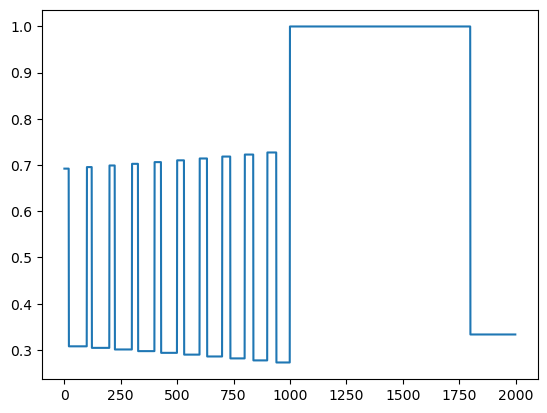

In [11]:
plt.plot(assorter_pop_unscaled)
# Correct CVRs always equal 1/(2-v) in ONEAudit, since we then divide the whole population by (2 / 2 - v) to map to [0,1]; CVRs always equal 1/2 in our mapping
# The global mean is (1/2) / (2 / 2-v) = (2-v) / 4 = 1/2 - v/4
# Is the mean for batches also always 1/2 ? 

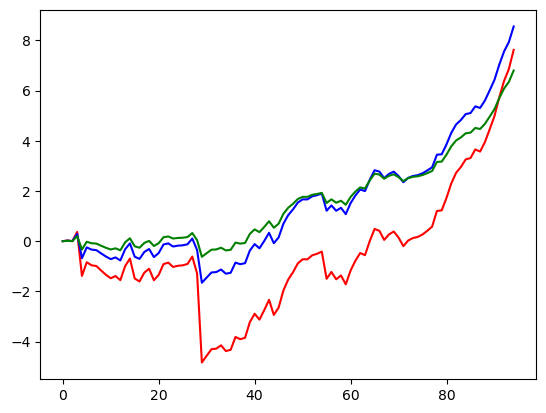

In [435]:
mart_mat = np.vstack(
    (mart(X_strat[0], eta = 0.5, lam = np.ones(len(X_strat[0])) * 2, N = N[0], log = True),
    mart(X_strat[0], eta = 0.5, lam = np.ones(len(X_strat[0])) * 1.5, N = N[0], log = True),
    mart(X_strat[0], eta = 0.5, lam = np.ones(len(X_strat[0])) * 1, N = N[0], log = True))
)

plt.plot(mart_mat[0,:], color = 'r')
plt.plot(mart_mat[1,:], color = 'b')
plt.plot(mart_mat[2,:], color = 'g')
plt.show()

In [424]:
np.transpose(mart_mat)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.31792301,  0.24740902,  0.17154303],
       [ 0.7291931 ,  0.57061479,  0.39817362],
       [ 1.32864865,  1.05047299,  0.74216289],
       [ 1.73729228,  1.37152808,  0.96721476],
       [ 2.27105687,  1.79614535,  1.26929524],
       [ 2.09193598,  1.66490119,  1.18373998],
       [ 2.40203488,  1.90601822,  1.35076174],
       [ 2.63737085,  2.0875064 ,  1.47533669],
       [ 2.6263283 ,  2.07923594,  1.46983065],
       [ 2.78274787,  2.19878412,  1.55109571],
       [ 2.7039656 ,  2.14028688,  1.5124802 ],
       [ 3.00998071,  2.37812366,  1.67714803],
       [ 3.08867104,  2.43771427,  1.71726702],
       [ 3.42173026,  2.69732278,  1.89759906],
       [ 3.32624656,  2.62657824,  1.85099642],
       [ 3.74879603,  2.95903172,  2.08442557],
       [ 4.13079653,  3.25832829,  2.29355653],
       [ 4.64298323,  3.66492776,  2.5820895 ],
       [ 4.46210778,  3.53242951,  2.4957357 ],
       [ 4.77874981,  3.77880774,  2.666

In [350]:
polarized = False
u = 1
A_c_bar = 0.55
num_batches = 10
batch_size = 100
num_cvrs = 1000
prop_invalid = 0.5
stratified = False
alpha = 0.05
delta_within = 0.5
delta_across = 0.5
bet = "kelly-optimal"
rep_grid = np.arange(1)
n_reps = len(rep_grid)
bets_dict = {
    "agrapa": lambda x, eta: Bets.agrapa(x, eta, c = 0.99),
    "alpha": "special handling", # see below
    "kelly-optimal": lambda x, eta: Bets.kelly_optimal(x, eta, c = 0.99)}
results = []


N = num_batches * batch_size + num_cvrs # population size
prop_cvrs = num_cvrs / N # proportion of votes that are CVRs
prop_batches = 1 - prop_cvrs # proportion of votes that are in batches

# means and sizes for batches
# A_c_bar = prop_batches * A_c_bar_batches + prop_cvrs * A_c_bar_cvrs
A_c_bar_batches = A_c_bar - 0.5 * delta_across # overall batch mean
if num_batches == 1:
    if polarized:
        "blah"
    else:
        A_c_batches = A_c_bar_batches
elif polarized:
    assert (num_batches % 2) == 0, "number of batches must be divisible by two to maintain bar mean with polarization"
    A_c_batches = np.append(
        (A_c_bar_batches - 0.5 * delta_within) * np.ones(int(num_batches/2)),
        (A_c_bar_batches + 0.5 * delta_within) * np.ones(int(num_batches/2))
    )
else:
    A_c_batches = np.linspace(
        A_c_bar_batches - 0.5 * delta_within,
        A_c_bar_batches + 0.5 * delta_within,
        num_batches)
batch_sizes = np.ones(num_batches) * batch_size
invalids = np.ones(num_batches) * prop_invalid


# make CVRs
prop_invalid_cvrs = 0.0
A_c_bar_cvrs = A_c_bar + 0.5 * delta_across
cvrs_i = num_cvrs * prop_invalid_cvrs # the number of CVRs showing invalid votes
cvrs_w = num_cvrs * A_c_bar_cvrs * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_l = num_cvrs * (1 - A_c_bar_cvrs) * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_iwl = [int(c) for c in saferound([cvrs_i, cvrs_w, cvrs_l], places = 0)] # rounding to integers
A_c_cvrs = np.repeat([1/2, 1, 0], cvrs_iwl)

# add CVRs
A_c = np.append(A_c_batches, A_c_cvrs)
batch_sizes = np.append(batch_sizes, np.ones(num_cvrs))
invalids = np.append(invalids, np.append(np.ones(cvrs_iwl[0]), np.zeros(cvrs_iwl[1] + cvrs_iwl[2])))

assorter_pop_unscaled = generate_oneaudit_population(
        batch_sizes = batch_sizes,
        A_c = A_c,
        invalid = invalids
    )
eta_0_unscaled = 1/2 # global null mean

realized_A_c_bar = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means
v_bar = 2 * realized_A_c_bar - 1 # global margin

# assorters and global null are rescaled to [0,1] for compatability with functions from utils
# NB: if stratification is used, may need to rethink rescaling: each stratum needs to be on [0,1] and the global null should still correspond to the assertion
assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_bar))
eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_bar))


# unstratified sampling
if bet == "alpha":
    # alpha (predictable bernoulli) get shrunk towards the true mean of the population
    bets_dict["alpha"] = lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.99, mu_0 = np.mean(assorter_pop))
if bet == "kelly-optimal":
    ko_bet = Bets.kelly_optimal(assorter_pop, eta_0)
X = np.random.permutation(assorter_pop) # the sample is a permutation of the population
# TSMs are computed for sampling WOR
start_time = time.time()
m_u = mart(X, eta = eta_0, lam = ko_bet, N = N, log = True)
run_time = start_time - time.time()
stopping_time_u = np.where(any(m_u > -np.log(alpha)), np.argmax(m_u > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size

# stratified sampling
strata = np.repeat(np.where(batch_sizes > 1, 0, 1), repeats = batch_sizes.astype("int")) # place ballots with CVRs (batch_size == 1) into stratum 1, and larger batches into stratum 0
K = 2 # the number of strata
N_strat = np.unique(strata, return_counts = True)[1] # the size of the population in each stratum

etas_10 = construct_eta_bands(eta_0, N_strat, n_bands = 10) # the null space, partitioned into bands
etas_100 = construct_eta_bands(eta_0, N_strat, n_bands = 100) # the null space, partitioned into bands
etas_1000 = construct_eta_bands(eta_0, N_strat, n_bands = 1000) # the null space, partitioned into bands
# 'draw' a stratified sample by shuffling the population within strata
X = []
for k in range(K):
    X.append(np.random.permutation(assorter_pop[strata == k]))
# TSMs are computed for sampling WOR
start_time = time.time()

if bet == "alpha":
    bets_dict["alpha"] = [lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.99, mu_0 = np.mean(assorter_pop[k])) for k in range(K)]

uits_10 = banded_uits(
    X,
    N = N_strat,
    etas = etas_10,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    log = True,
    WOR = True,
    verbose = True)
m_10 = uits_10[0]
stopping_time_10 = np.where(any(m_10 > -np.log(alpha)), np.argmax(m_10 > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size


uits_100 = banded_uits(
    X,
    N = N_strat,
    etas = etas_100,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    log = True,
    WOR = True,
    verbose = True)
m_100 = uits_100[0]
stopping_time_100 = np.where(any(m_100 > -np.log(alpha)), np.argmax(m_100 > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size


uits_1000 = banded_uits(
    X,
    N = N_strat,
    etas = etas_1000,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    log = True,
    WOR = True,
    verbose = True)
m_1000 = uits_1000[0]
stopping_time_1000 = np.where(any(m_1000 > -np.log(alpha)), np.argmax(m_1000 > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size

glcb = global_lower_bound(
    X,
    N_strat,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    alpha = 0.05,
    WOR = True
)
stopping_time_glcb = np.where(any(glcb > eta_0), np.argmax(glcb > eta_0), N)

print(f"unstratified stopping time: {stopping_time_u}\nstratified stopping time 10: {stopping_time_10}\nstratified stopping time 100: {stopping_time_100}\nstratified stopping time 1000: {stopping_time_1000}\nlcb stopping time: {stopping_time_glcb}")

unstratified stopping time: 46
stratified stopping time 10: 114
stratified stopping time 100: 53
stratified stopping time 1000: 49
lcb stopping time: 87


array([[0.00475, 0.94525],
       [0.54625, 0.40375],
       [0.51775, 0.43225],
       [0.54625, 0.40375],
       [0.54625, 0.40375],
       [0.54625, 0.40375],
       [0.52725, 0.42275],
       [0.51775, 0.43225],
       [0.51775, 0.43225],
       [0.50825, 0.44175],
       [0.50825, 0.44175],
       [0.50825, 0.44175],
       [0.50825, 0.44175],
       [0.50825, 0.44175],
       [0.50825, 0.44175],
       [0.50825, 0.44175],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
       [0.49875, 0.45125],
 

In [299]:
uits_1000[0][0:50]

array([0.        , 0.        , 0.18961809, 0.22326856, 0.44445034,
       0.44445034, 0.47410412, 0.48413884, 0.54093864, 0.86627998,
       1.0249528 , 1.0249528 , 1.0249528 , 1.0249528 , 1.03265244,
       1.03265244, 1.03265244, 1.19271604, 1.26993857, 1.26993857,
       1.32299951, 1.83003404, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395])

In [211]:
uits_1000[3][525][0:50]

array([0.        , 0.09852984, 0.20263557, 0.50232692, 0.60587625,
       0.60587625, 0.60587625, 0.60587625, 0.60587625, 0.93623758,
       1.03962737, 1.03962737, 1.03962737, 1.03962737, 1.03962737,
       1.03962737, 1.03962737, 1.20422821, 1.30761184, 1.30761184,
       1.36907776, 1.83692299, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395,
       1.94049395, 1.94049395, 1.94049395, 1.94049395, 1.94049395])

In [210]:
etas_1000[525]

[(array([0.49875, 0.45125]), array([0.4997, 0.4503])),
 array([0.499225, 0.450775])]

In [222]:
for k in range(2):
    print(uits_1000[5][525][k][40])

1.7660148280528685
2.216066481994461


In [314]:
etas = etas_1000
i = 525
x = X
WOR = False
log = True
lam_func = [bets_dict['kelly-optimal']] * K
N = [len(x_k) for x_k in x]
w = N / np.sum(N)
n = [x_k.shape[0] for x_k in x] #get the sample size
ws_N = N if WOR else np.inf*np.ones(K)
obj = np.zeros((len(etas), np.sum(n) + 1))
sel = np.zeros((len(etas), np.sum(n) + 1, K))
min_etas = []
bets = []
allocation_func = Allocations.proportional_round_robin

centroid_eta = etas[i][1]
max_eta = np.max(np.vstack(etas[i][0]),0) #record largest eta in the band for each stratum
#bets are determined for max_eta, which makes the bets conservative for both strata and both vertices of the band
bets_i = [mart(x[k], max_eta[k], lam_func[k], None, ws_N[k], log, output = "bets") for k in np.arange(K)]
bets.append(bets_i)
#selections are determined by the centroid
T_k_i = selector(x, N, allocation_func, centroid_eta, bets_i)
itsm_mat = np.zeros((np.sum(n)+1, 2))
#minima are evaluated at the endpoints of the band//
#one of which is the minimum over the whole band due to concavity
for j in np.arange(2):
    itsm_mat[:,j] = intersection_mart(x = x, N = N, eta = etas[i][0][j], lam = bets_i, T_k = T_k_i,
        combine = "product", log = log, WOR = WOR, running_max = False)
obj[i,:] = np.min(itsm_mat, 1)
sel[i,:,:] = T_k_i

In [322]:
eta = etas[i][0][0]
lam = bets_i
ws_log = log
ws_marts = [mart(x[k], eta[k], None, lam[k], ws_N[k], ws_log) for k in np.arange(K)]
marts = np.zeros((T_k_i.shape[0], K))
for i in np.arange(T_k_i.shape[0]):
    marts_i = np.array([ws_marts[k][T_k_i[i, k]] for k in np.arange(K)])
    #make all marts infinite if one is, when product is taken this enforces rule:
    #we reject intersection null if certainly False in one stratum
    #TODO: rethink this logic? What if the null is certainly true in a stratum?
    #there is some more subtlety to be considered when sampling WOR
    marts[i,:] = marts_i if not any(np.isposinf(marts_i)) else np.inf * np.ones(K)

np.float64(0.4987499999999998)

In [317]:
mart(x[1], N = N[1], eta = etas[i][0][0][1], lam = bets_i[1])[0:50] + mart(x[0], N = N[0], eta = etas[i][0][0][0], lam = bets_i[0])[0:50]

array([ 0.        ,  0.20263557,  0.60587625,  0.22272359,  0.46914234,
        1.03962737,  0.80527375,  1.00898294,  0.9034254 ,  1.30761184,
        1.36907776,  1.94049395,  1.47672989,  1.17200803,  1.00462552,
        0.62248714,  0.45447592, -0.01170568,  0.0489604 ,  0.41621985,
        0.57490351,  0.94264452,  1.23233746,  1.43726326,  0.88198727,
        1.5701508 ,  1.18942635,  1.08516046,  0.85178596,  1.05690927,
        1.49838899,  1.33218132,  1.4924584 ,  1.50283398,  1.79374749,
        1.99989753,  2.2912848 ,  2.05950631,  2.22059436,  2.38184264,
        2.78903269,  2.74548789,  2.28319134,  2.29463953,  2.77214416,
        3.10456657,  3.35577176,  3.054369  ,  3.38717089,  3.63876206])

In [318]:
itsm_mat[0:50,1]

array([ 0.        ,  0.09852984,  0.20301463,  0.50225008,  0.60673487,
        0.1173244 ,  0.22180918,  0.36383231,  0.4683171 ,  0.93463081,
        1.03911559,  0.69817281,  0.8026576 ,  0.90118744,  1.00567223,
        0.7939773 ,  0.89846209,  1.19769755,  1.30218233,  1.25758178,
        1.36206657,  1.82838028,  1.93286507,  1.36004292,  1.46452771,
        1.05210389,  1.15658867,  0.8823565 ,  0.98684128,  0.49743081,
        0.6019156 ,  0.32768342,  0.43216821, -0.14065394, -0.03616915,
       -0.0807697 ,  0.02371509,  0.28590334,  0.39038813,  0.44344666,
        0.54793145,  0.8101197 ,  0.91460449,  1.09830782,  1.2027926 ,
        1.30132244,  1.40580723,  0.74197752,  0.8464623 ,  1.42886275])

In [301]:
itsm_mat[0:50,0]

array([0.        , 0.10004898, 0.20263557, 0.50311408, 0.60570067,
       0.60570067, 0.60570067, 0.60570067, 0.60570067, 0.93503984,
       1.03762643, 1.03762643, 1.03762643, 1.03762643, 1.03762643,
       1.03762643, 1.03762643, 1.19770366, 1.30029025, 1.30029025,
       1.36002899, 1.82739459, 1.92998118, 1.92998118, 1.92998118,
       1.92998118, 1.92998118, 1.92998118, 1.92998118, 1.92998118,
       1.92998118, 1.92998118, 1.92998118, 1.92998118, 1.92998118,
       1.92998118, 1.92998118, 1.92998118, 1.92998118, 1.92998118,
       1.92998118, 1.92998118, 1.92998118, 1.92998118, 1.92998118,
       1.92998118, 1.92998118, 1.92998118, 1.92998118, 1.92998118])

In [276]:
print(Bets.kelly_optimal(x[0], eta = etas[i][1][0])[0])
print(Bets.kelly_optimal(x[0], eta = etas[i][0][0][0])[0])
print(Bets.kelly_optimal(x[0], eta = etas[i][0][1][0])[0])

1.782229961809107
1.7984358257832762
1.7660148280528685


In [262]:
etas[i]

[(array([0.49875, 0.45125]), array([0.4997, 0.4503])),
 array([0.499225, 0.450775])]

In [285]:
mart(x[0], N = N[0], eta = etas[i][0][0][0], lam = bets_i[0])[0:50]

array([ 0.        ,  0.10004898,  0.40060548, -0.08532914,  0.05820968,
        0.52571663,  0.18828659,  0.28882084,  0.07998963,  0.3808035 ,
        0.33879776,  0.80664299,  0.23920851, -0.16928345, -0.44053592,
       -0.92664432, -1.19872579, -1.76907809, -1.81268334, -1.54979605,
       -1.49558558, -1.23241898, -1.04740187, -0.94725351, -1.60740875,
       -1.02422647, -1.5100344 , -1.71948617, -2.05814915, -1.95841713,
       -1.62243172, -1.8942369 , -1.83966076, -1.93508971, -1.75008458,
       -1.64994692, -1.46467627, -1.80267582, -1.74791347, -1.69309573,
       -1.39244128, -1.54262694, -2.11166982, -2.20707363, -1.8365269 ,
       -1.61116849, -1.46713361, -1.8758132 , -1.65039487, -1.50629421])

In [289]:
mart(x[1], N = N[1], eta = etas[i][0][0][1], lam = bets_i[1])[0:50] + mart(x[0], N = N[0], eta = etas[i][0][0][0], lam = bets_i[0])[0:50]

array([ 0.        ,  0.20263557,  0.60587625,  0.22272359,  0.46914234,
        1.03962737,  0.80527375,  1.00898294,  0.9034254 ,  1.30761184,
        1.36907776,  1.94049395,  1.47672989,  1.17200803,  1.00462552,
        0.62248714,  0.45447592, -0.01170568,  0.0489604 ,  0.41621985,
        0.57490351,  0.94264452,  1.23233746,  1.43726326,  0.88198727,
        1.5701508 ,  1.18942635,  1.08516046,  0.85178596,  1.05690927,
        1.49838899,  1.33218132,  1.4924584 ,  1.50283398,  1.79374749,
        1.99989753,  2.2912848 ,  2.05950631,  2.22059436,  2.38184264,
        2.78903269,  2.74548789,  2.28319134,  2.29463953,  2.77214416,
        3.10456657,  3.35577176,  3.054369  ,  3.38717089,  3.63876206])

In [284]:
mart(x[1], N = N[1], eta = etas[i][0][1][1], lam = bets_i[1])[0:50] + mart(x[0], N = N[0], eta = etas[i][0][1][0], lam = bets_i[0])[0:50]

array([ 0.        ,  0.20301463,  0.60691102,  0.22292332,  0.4697866 ,
        1.04112073,  0.80630823,  1.01039838,  0.90466701,  1.30951277,
        1.37112527,  1.94339491,  1.47855163,  1.1731906 ,  1.00549683,
        0.62251042,  0.45418506, -0.01309106,  0.04771838,  0.41559296,
        0.57458662,  0.94294399,  1.2331465 ,  1.43845573,  0.88178965,
        1.57093351,  1.18935008,  1.08490185,  0.85105071,  1.05655796,
        1.49875131,  1.33222222,  1.4928113 ,  1.50323295,  1.79465988,
        2.00119565,  2.29309739,  2.06083756,  2.22223861,  2.38380012,
        2.79166423,  2.74805577,  2.28463497,  2.29612764,  2.77439603,
        3.10739324,  3.35905463,  3.05698229,  3.39036022,  3.64240849])

In [149]:
polarized = False
u = 1
A_c_global = 0.7
num_batches = 10
batch_size = 100
num_cvrs = 1000
prop_invalid = 0.5
stratified = False
alpha = 0.05
delta = 0.0
bet = "kelly-optimal"
rep_grid = np.arange(1)
n_reps = len(rep_grid)
bets_dict = {
    "agrapa": lambda x, eta: Bets.agrapa(x, eta, c = 0.99),
    "alpha": "special handling", # see below
    "kelly-optimal": lambda x, eta: Bets.kelly_optimal(x, eta, c = 0.99)}
results = []


u = 1 # upper bound for plurality assorters

# means and sizes for batches
if num_batches == 1:
    if polarized:
        "boop"
    else:
        A_c = A_c_global
elif polarized:
    assert (num_batches % 2) == 0, "number of batches must be divisible by two to maintain global mean with polarization"
    A_c = np.append(
        (A_c_global - 0.5 * delta) * np.ones(int(num_batches/2)),
        (A_c_global + 0.5 * delta) * np.ones(int(num_batches/2))
    )
else:
    A_c = np.linspace(A_c_global - 0.5 * delta, A_c_global + 0.5 * delta, num_batches)
batch_sizes = np.ones(num_batches) * batch_size
invalids = np.ones(num_batches) * prop_invalid


# make CVRs
cvrs_i = num_cvrs * prop_invalid # the number of CVRs showing invalid votes
cvrs_w = num_cvrs * A_c_global * (1 - prop_invalid) # the number of CVRs showing votes for the winner
cvrs_l = num_cvrs * (1 - A_c_global) * (1 - prop_invalid) # the number of CVRs showing votes for the winner
cvrs_iwl = [int(c) for c in saferound([cvrs_i, cvrs_w, cvrs_l], places = 0)] # rounding to integers
A_c_cvrs = np.repeat([1/2, 1, 0], cvrs_iwl)

# add CVRs
A_c = np.append(A_c, A_c_cvrs)
batch_sizes = np.append(batch_sizes, np.ones(num_cvrs))
invalids = np.append(invalids, np.append(np.ones(cvrs_iwl[0]), np.zeros(cvrs_iwl[1] + cvrs_iwl[2])))

assorter_pop_unscaled = generate_oneaudit_population(
        batch_sizes = batch_sizes,
        A_c = A_c,
        invalid = invalids
    )
eta_0_unscaled = 1/2 # global null mean

realized_A_c_global = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means
v_global = 2 * realized_A_c_global - 1 # global margin

# assorters and global null are rescaled to [0,1] for compatability with functions from utils
# NB: if stratification is used, may need to rethink rescaling: each stratum needs to be on [0,1] and the global null should still correspond to the assertion
assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_global))
eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_global))

N = len(assorter_pop) # the size of the population/sample
stopping_times = np.zeros(n_reps) # container for stopping times in each simulation
run_times = np.zeros(n_reps) # container for run times in each simulation


# unstratified sampling
if bet == "alpha":
    # alpha (predictable bernoulli) get shrunk towards the true mean of the population
    bets_dict["alpha"] = lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.99, mu_0 = np.mean(assorter_pop))
if bet == "kelly-optimal":
    ko_bet = Bets.kelly_optimal(assorter_pop, eta_0)
X = np.random.permutation(assorter_pop) # the sample is a permutation of the population
# TSMs are computed for sampling WOR
start_time = time.time()
m_u = mart(X, eta = eta_0, lam = ko_bet, N = N, log = True)
run_time = start_time - time.time()
stopping_time_u = np.where(any(m_u > -np.log(alpha)), np.argmax(m_u > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size

# stratified sampling
strata = np.repeat(np.where(batch_sizes > 1, 0, 1), repeats = batch_sizes.astype("int")) # place ballots with CVRs (batch_size == 1) into stratum 1, and larger batches into stratum 0
K = 2 # the number of strata
N_strat = np.unique(strata, return_counts = True)[1] # the size of the population in each stratum

etas_10 = construct_eta_bands(eta_0, N_strat, n_bands = 10) # the null space, partitioned into bands
etas_100 = construct_eta_bands(eta_0, N_strat, n_bands = 100) # the null space, partitioned into bands
etas_1000 = construct_eta_bands(eta_0, N_strat, n_bands = 1000) # the null space, partitioned into bands
# 'draw' a stratified sample by shuffling the population within strata
X = []
for k in range(K):
    X.append(np.random.permutation(assorter_pop[strata == k]))
# TSMs are computed for sampling WOR
start_time = time.time()

if bet == "alpha":
    bets_dict["alpha"] = [lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.99, mu_0 = np.mean(assorter_pop[k])) for k in range(K)]

uits_10 = banded_uits(
    X,
    N = N_strat,
    etas = etas_10,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    log = True,
    WOR = True,
    verbose = True)
m_10 = uits_10[0]
stopping_time_10 = np.where(any(m_10 > -np.log(alpha)), np.argmax(m_10 > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size


uits_100 = banded_uits(
    X,
    N = N_strat,
    etas = etas_100,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    log = True,
    WOR = True,
    verbose = True)
m_100 = uits_100[0]
stopping_time_100 = np.where(any(m_100 > -np.log(alpha)), np.argmax(m_100 > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size

uits_1000 = banded_uits(
    X,
    N = N_strat,
    etas = etas_1000,
    lam_func = bets_dict[bet],
    allocation_func = Allocations.proportional_round_robin,
    log = True,
    WOR = True,
    verbose = True)
m_1000 = uits_1000[0]
stopping_time_1000 = np.where(any(m_1000 > -np.log(alpha)), np.argmax(m_1000 > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size



print(f"unstratified stopping time: {stopping_time_u}\nstratified stopping time 10: {stopping_time_10}\nstratified stopping time 100: {stopping_time_100}\nstratified stopping time 1000: {stopping_time_1000}")

unstratified stopping time: 229
stratified stopping time 10: 93
stratified stopping time 100: 30
stratified stopping time 1000: 28


In [150]:
uits_100[1][1:10,:]

array([[0.44625, 0.40375],
       [0.44625, 0.40375],
       [0.44625, 0.40375],
       [0.44625, 0.40375],
       [0.44625, 0.40375],
       [0.42925, 0.42075],
       [0.44625, 0.40375],
       [0.44625, 0.40375],
       [0.44625, 0.40375]])

In [151]:
uits_1000[1][1:10,:]

array([[0.450075, 0.399925],
       [0.450075, 0.399925],
       [0.450075, 0.399925],
       [0.449225, 0.400775],
       [0.449225, 0.400775],
       [0.423725, 0.426275],
       [0.449225, 0.400775],
       [0.449225, 0.400775],
       [0.449225, 0.400775]])

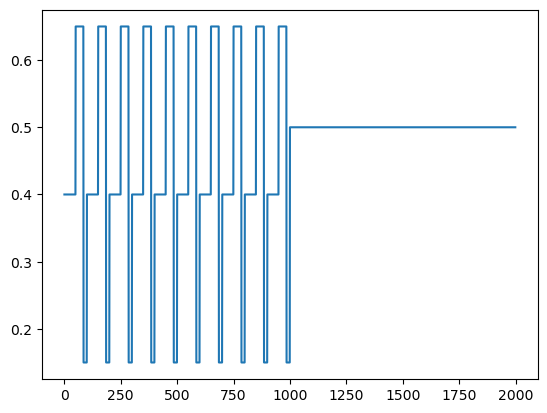

In [153]:
plt.plot(assorter_pop)

In [44]:
np.concatenate((A_c, np.ones(cvrs_iwl[1]), np.zeros(cvrs_iwl[2])))

ValueError: zero-dimensional arrays cannot be concatenated

In [191]:
A_c_global = 0.51
delta_across = 0.5
delta_within = 0.5
N = num_batches * batch_size + num_cvrs # population size
prop_cvrs = num_cvrs / N # proportion of votes that are CVRs
prop_batches = 1 - prop_cvrs # proportion of votes that are in batches


# means and sizes for batches
# A_c_global = prop_batches * A_c_global_batches + prop_cvrs * A_c_global_cvrs
A_c_global_batches = A_c_global - 0.5 * delta_across # overall batch mean
if num_batches == 1:
    if polarized:
        "blah"
    else:
        A_c_batches = A_c_global_batches
elif polarized:
    assert (num_batches % 2) == 0, "number of batches must be divisible by two to maintain global mean with polarization"
    A_c_batches = np.append(
        (A_c_global_batches - 0.5 * delta_within) * np.ones(int(num_batches/2)),
        (A_c_global_batches + 0.5 * delta_within) * np.ones(int(num_batches/2))
    )
else:
    A_c_batches = np.linspace(
        A_c_global_batches - 0.5 * delta_within,
        A_c_global_batches + 0.5 * delta_within,
        num_batches)
batch_sizes = np.ones(num_batches) * batch_size
invalids = np.ones(num_batches) * prop_invalid


# make CVRs
prop_invalid_cvrs = 0.0
A_c_global_cvrs = A_c_global + 0.5 * delta_across
cvrs_i = num_cvrs * prop_invalid_cvrs # the number of CVRs showing invalid votes
cvrs_w = num_cvrs * A_c_global_cvrs * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_l = num_cvrs * (1 - A_c_global_cvrs) * (1 - prop_invalid_cvrs) # the number of CVRs showing votes for the winner
cvrs_iwl = [int(c) for c in saferound([cvrs_i, cvrs_w, cvrs_l], places = 0)] # rounding to integers
A_c_cvrs = np.repeat([1/2, 1, 0], cvrs_iwl)

A_c = np.append(A_c_batches, A_c_cvrs)
batch_sizes = np.append(batch_sizes, np.ones(num_cvrs))
invalids = np.append(invalids, np.append(np.ones(cvrs_iwl[0]), np.zeros(cvrs_iwl[1] + cvrs_iwl[2])))

assorter_pop_unscaled = generate_oneaudit_population(
        batch_sizes = batch_sizes,
        A_c = A_c,
        invalid = invalids
    )
eta_0_unscaled = 1/2 # global null mean

realized_A_c_global = np.dot(batch_sizes / np.sum(batch_sizes), A_c) # the actual global mean based on the batch sizes and means
v_global = 2 * realized_A_c_global - 1 # global margin

# assorters and global null are rescaled to [0,1] for compatability with functions from utils
# NB: if stratification is used, may need to rethink rescaling: each stratum needs to be on [0,1] and the global null should still correspond to the assertion
assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_global))
eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_global))


In [192]:
np.mean(A_c_cvrs), A_c_global_cvrs

(np.float64(0.76), 0.76)

In [176]:
(A_c_global_batches + A_c_global_cvrs)/2

0.51

In [80]:
strata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [79]:
np.repeat(strata, repeats = batch_sizes.astype("int"))

array([0, 0, 0, ..., 1, 1, 1], shape=(1010,))

In [73]:
assorter_pop

array([0.73397516, 0.73397516, 0.73397516, ..., 0.56459627, 0.56459627,
       0.56459627], shape=(1010,))

In [33]:
%%time
A_c_global = 0.6
delta = 0.3
num_batches = 2
batch_size = 10 
prop_invalid = 0 
bet = "agrapa" 
n_cvrs = 5000
polarized = True


u = 1 # upper bound for plurality assorters
v_global = 2 * A_c_global - 1 # global margin

# means and sizes for batches
if polarized:
    assert (num_batches % 2) == 0, "number of batches must be divisible by two to maintain global mean with polarization"
    A_c = np.append(
        (A_c_global - 0.5 * delta) * np.ones(int(num_batches/2)),
        (A_c_global + 0.5 * delta) * np.ones(int(num_batches/2))
    )
else:
    A_c = np.linspace(A_c_global - 0.5 * delta, A_c_global + 0.5 * delta, num_batches)
batch_sizes = np.ones(num_batches) * batch_size
invalids = np.ones(num_batches) * prop_invalid

# means and sizes for CVRs
A_c = np.append(A_c, np.ones(n_cvrs))
batch_sizes = np.append(batch_sizes, np.ones(n_cvrs))
invalids = np.append(invalids, np.zeros(n_cvrs))

assorter_pop_unscaled = generate_oneaudit_population(
    batch_sizes = batch_sizes,
    A_c = A_c,
    invalid = invalids
)
eta_0_unscaled = (1/2) # global null mean

# assorters and global null are rescaled to [0,1] for compatability with functions from utils
# NB: if stratification is used, may need to rethink rescaling: each stratum needs to be on [0,1] and the global null should still correspond to the assertion
assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_global))
eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_global))
N = len(assorter_pop) # the size of the population/sample
assorter_pop

CPU times: user 127 ms, sys: 2.94 ms, total: 130 ms
Wall time: 131 ms


array([1.39056791, 1.39056791, 1.39056791, ..., 0.89714059, 0.89714059,
       0.89714059], shape=(5020,))

array([0.2, 1. , 1. , 1. , 1. , 1. , 1. ])

In [26]:
%%time

A_c_global_grid = np.linspace(0.51, 0.75, 20) # global assorter means
delta_grid = [0, 0.1, 0.5] # maximum spread between batches, assuming batches are equally spread
num_batch_grid = [2, 10, 100] # the number of batches
batch_size_grid = [100] # assuming for now, equally sized batches
prop_invalid_grid = [0, 0.1, 0.5]
alpha = 0.05 # risk limit
n_reps = 30 # the number of replicate simulations

bets_dict = {
    "agrapa":lambda x, eta: Bets.agrapa(x, eta, c = 0.99),
    "alpha": lambda x, eta: Bets.inverse_eta(x, eta, c = 0.99),
    #"grapa": lambda x, eta: Bets.grapa(x, eta, c = 0.99),
    "kelly-optimal": "special handling"}
bets_grid = list(bets_dict.keys())

results = []

for A_c_global, delta, num_batches, batch_size, prop_invalid, bet in itertools.product(A_c_global_grid, delta_grid, num_batch_grid, batch_size_grid, prop_invalid_grid, bets_grid):
    u = 1 # upper bound for plurality assorters
    v_global = 2 * A_c_global - 1 # global margin
    A_c = np.linspace(A_c_global - 0.5 * delta, A_c_global + 0.5 * delta, num_batches)
    batch_sizes = np.ones(num_batches) * batch_size


    assorter_pop_unscaled = generate_oneaudit_population(batch_sizes = batch_sizes, A_c = A_c, invalid =  prop_invalid*np.ones(num_batches))
    eta_0_unscaled = (1/2) # global null mean

    # assorters and global null are rescaled to [0,1] for compatability with functions from utils
    # NB: if stratification is used, may need to rethink rescaling: each stratum needs to be on [0,1] and the global null should still correspond to the assertion
    assorter_pop = assorter_pop_unscaled / (2 * u / (2 * u - v_global))
    eta_0 = eta_0_unscaled / (2 * u / (2 * u - v_global))
    N = len(assorter_pop) # the size of the population/sample

    #derive kelly-optimal bet one time by applying numerical optimization to entire population
    if bet == "kelly-optimal":
        ko_bet = Bets.kelly_optimal(assorter_pop, eta_0)

    stopping_times = np.zeros(n_reps) # container for stopping times in each simulation
    run_times = np.zeros(n_reps) # container for run times in each simulation
    for r in range(n_reps):
        X = np.random.permutation(assorter_pop) # the sample is a permutation of the population
        # TSMs are computed for sampling WOR
        start_time = time.time()
        if bet == "kelly-optimal":
            m = mart(X, eta = eta_0, lam = ko_bet * np.ones(N), N = N, log = True)
        else:
            m = mart(X, eta = eta_0, lam_func = bets_dict[bet], N = N, log = True)
        run_time = time.time() - start_time
        stopping_time = np.where(any(m > -np.log(alpha)), np.argmax(m > -np.log(alpha)), N) # where the TSM crosses 1/alpha, or else the population size
        stopping_times[r] = stopping_time
        run_times[r] = run_time

    expected_sample_size = np.mean(stopping_times)
    percentile_sample_size = np.percentile(stopping_times, 90)


    data_dict = {
        "A_c_global":A_c_global,
        "delta":delta,
        "num_batches":num_batches,
        "batch_size":batch_size,
        "prop_invalid":prop_invalid,
        "bet":str(bet),
        "expected_sample_size":expected_sample_size,
        "90th_percentile_sample_size":percentile_sample_size,
        "run_time":run_time}
    results.append(data_dict)
results = pd.DataFrame(results)
results.to_csv("one_audit_results.csv", index = False)

CPU times: user 9min 46s, sys: 3.14 s, total: 9min 49s
Wall time: 9min 49s


In [27]:
results

,A_c_global,delta,num_batches,batch_size,prop_invalid,bet,expected_sample_size,90th_percentile_sample_size,run_time
0,0.51,0.0,2,100,0.0,agrapa,187.000000,200.0,0.002105
1,0.51,0.0,2,100,0.0,alpha,193.400000,200.0,0.000081
2,0.51,0.0,2,100,0.0,kelly-optimal,199.300000,200.0,0.000077
3,0.51,0.0,2,100,0.1,agrapa,198.833333,200.0,0.002270
4,0.51,0.0,2,100,0.1,alpha,193.233333,200.0,0.000084
...,...,...,...,...,...,...,...,...,...
1615,0.75,0.5,100,100,0.1,alpha,20.933333,44.7,0.000246
1616,0.75,0.5,100,100,0.1,kelly-optimal,16.766667,30.1,0.000247
1617,0.75,0.5,100,100,0.5,agrapa,41.133333,82.7,0.094451
1618,0.75,0.5,100,100,0.5,alpha,34.366667,65.8,0.000264


In [5]:
lam

array([0., 2., 2.])

In [12]:
x = np.array([1, 0.5, 0.5, 0.2, 0.2, 0.2])
eta = 1/2 
deriv = lambda lam: np.sum((x - eta) / (1 + lam * (x - eta)))
deriv(0.4)
#lam_star = sp.optimize.root_scalar(deriv, bracket = [0, 1/eta], method = 'bisect')
#lam_star

np.float64(-0.606060606060606)

In [7]:
batch_sizes = np.array([10, 10, 10])
A_c = np.array([0.8, 0.8, 0.4])
invalid = np.array([0.1, 0.1, 0.1])

B = len(batch_sizes) # the number of batches
u = 1 # the upper bound on the original assorters for plurality contests
batches = []
for i in range(B):
    v = 2 * A_c[i] - 1 # reported assorter margin
    # these votes are possibly fractional and need to be rounded
    invalid_votes = batch_sizes[i] * invalid[i] # the number of invalid votes
    votes_for_winner = batch_sizes[i] * A_c[i] * (1 - invalid[i]) # the number of votes for the winner
    votes_for_loser = batch_sizes[i] * (1 - A_c[i]) * (1 - invalid[i]) # the number of votes for the loser
    # rounding while preserving the sum
    votes = saferound([invalid_votes, votes_for_winner, votes_for_loser], places = 0)
    votes = [int(vote) for vote in votes] # conversion to integers
    
    # ONE assorter values
    B_i = (u + 1/2 - A_c[i]) / (2 * u - v) # assorter for invalid votes
    B_w = (u + 1 - A_c[i]) / (2 * u - v) # assorter for winner votes
    B_l = (u + 0 - A_c[i]) / (2 * u - v) # assorter for loser votes

    # assorter populations as an array
    batches.append(np.concatenate([B_i * np.ones(votes[0]), B_w * np.ones(votes[1]), B_l * np.ones(votes[2])]))
pop = np.concatenate(batches)

In [9]:
pop

array([0.5       , 0.85714286, 0.85714286, 0.85714286, 0.85714286,
       0.85714286, 0.85714286, 0.85714286, 0.14285714, 0.14285714,
       0.5       , 0.85714286, 0.85714286, 0.85714286, 0.85714286,
       0.85714286, 0.85714286, 0.85714286, 0.14285714, 0.14285714,
       0.5       , 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.27272727, 0.27272727, 0.27272727, 0.27272727, 0.27272727])

In [52]:
N = [20, 20]
A_c = [0.8, 0.8]
p_1 = [0.0, 0.0]
p_2 = [0.0, 0.0]
lam_func = Bets.agrapa 
allocation_func = Allocations.round_robin
method = "ui-ts"
WOR = False
reps = 1
n_bands = 100
alpha = 0.05

In [53]:
K = len(N)
u = 2 # the upper bound on the overstatment assorters, per STS
eta_0 = 1/2 # the global null in terms of the original assorters
assert K == 2, "only works for two strata"
w = N / np.sum(N)
assert np.dot(w, A_c) > 1/2, "reported assorter mean (A_c) implies the winner lost"
eta_1_grid = np.linspace(max(0, eta_0 - w[1]), min(u, eta_0/w[0]), n_bands + 1)
eta_2_grid = (eta_0 - w[0] * eta_1_grid) / w[1]
# transformed overstatement assorters
# the transofmration is per STS, except divided by 2
# the division by 2 allows a plurality CCA population to be defined on [0,1] instead of [0,2]
beta_1_grid = (eta_1_grid + 1 - A_c[0])/2 # transformed null means in stratum 1
beta_2_grid = (eta_2_grid + 1 - A_c[1])/2 # transformed null means in stratum 2
beta_grid = np.transpose(np.vstack((beta_1_grid, beta_2_grid)))
betas = []
for i in np.arange(beta_grid.shape[0]-1):
    centroid = (beta_grid[i,:] + beta_grid[i+1,:]) / 2
    betas.append([(beta_grid[i,:], beta_grid[i+1,:]), centroid])

In [54]:
construct_eta_bands_plurcomp(A_c, N, n_bands)

[[(array([0.1, 0.6]), array([0.105, 0.595])), array([0.1025, 0.5975])],
 [(array([0.105, 0.595]), array([0.11, 0.59])), array([0.1075, 0.5925])],
 [(array([0.11, 0.59]), array([0.115, 0.585])), array([0.1125, 0.5875])],
 [(array([0.115, 0.585]), array([0.12, 0.58])), array([0.1175, 0.5825])],
 [(array([0.12, 0.58]), array([0.125, 0.575])), array([0.1225, 0.5775])],
 [(array([0.125, 0.575]), array([0.13, 0.57])), array([0.1275, 0.5725])],
 [(array([0.13, 0.57]), array([0.135, 0.565])), array([0.1325, 0.5675])],
 [(array([0.135, 0.565]), array([0.14, 0.56])), array([0.1375, 0.5625])],
 [(array([0.14, 0.56]), array([0.145, 0.555])), array([0.1425, 0.5575])],
 [(array([0.145, 0.555]), array([0.15, 0.55])), array([0.1475, 0.5525])],
 [(array([0.15, 0.55]), array([0.155, 0.545])), array([0.1525, 0.5475])],
 [(array([0.155, 0.545]), array([0.16, 0.54])), array([0.1575, 0.5425])],
 [(array([0.16, 0.54]), array([0.165, 0.535])), array([0.1625, 0.5375])],
 [(array([0.165, 0.535]), array([0.17, 0

In [57]:
K = len(N)
w = N/np.sum(N)
A_c_global = np.dot(w, A_c)
betas = construct_eta_bands_plurcomp(A_c, N, n_bands)

x = []
v = 2 * A_c_global - 1 # global diluted margin
a = 1/(2-v) # where the pointmass would be for a global (unstratified) CCA

#construct assorter population within each stratum
for k in np.arange(K):
    num_points = [int(n_err) for n_err in saferound([N[k]*p_2[k], N[k]*p_1[k], N[k]*(1-p_2[k]-p_1[k])], places = 0)]
    x.append(1/2 * np.concatenate([np.zeros(num_points[0]), np.ones(num_points[1]) * 1/2, np.ones(num_points[2])]))

stopping_times = np.zeros(reps) #container for global stopping times
sample_sizes = np.zeros(reps) #container for global sample sizes
for r in np.arange(reps):
    X = [np.random.choice(x[k],  len(x[k]), replace = (not WOR)) for k in np.arange(K)] #shuffle (WOR) or sample (WR) a length-N_k sequence from each stratum k
    if method == "ui-ts":
        uits, eta_min, global_ss = banded_uits(X, N, betas, lam_func, allocation_func, log = True, WOR = WOR)
        stopping_times[r] = np.where(any(uits > -np.log(alpha)), np.argmax(uits > -np.log(alpha)), np.sum(N))
        sample_sizes[r] = global_ss[int(stopping_times[r])]
    elif method == "lcbs":
        eta_0 = (1/2 + 1 - A_c_global)/2
        lcb = global_lower_bound(X, N, lam_func, allocation_func, alpha, WOR = WOR, breaks = 1000)
        stopping_times[r] = np.where(any(lcb > eta_0), np.argmax(lcb > eta_0), np.sum(N))
        sample_sizes[r] = stopping_times[r]

In [60]:
stopping_times

array([12.])

In [4]:
%%time 
K = 50
N = [10 for _ in range(K)]
x_alt_1 = [random_truncated_gaussian(0.8, 0.05, N[k]) for k in range (K)]
convex_uits(x_alt_1, N, Allocations.round_robin, eta_0 = 0.5)[0]


CPU times: user 4min 19s, sys: 786 ms, total: 4min 19s
Wall time: 4min 20s


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   6.77488999,   6.7980811 ,
         6.81060786,   6.91051826,   6.95967668,   6.98888217,
         7.11072031,   7.22767984,   7.35661893,   7.52959959,
         7.65746987,   7.79257354,   7.95464298,   8.08

In [2]:
N = [10, 10, 10]
K = len(N)
x = [np.random.normal(0.5, 0.1, size = N[k]) for k in range(K)]
log = False
eta_0 = 0.5
allocation_func = Allocations.round_robin
w = N / np.sum(N) #stratum weights
n = [x[k].shape[0] for k in range(K)]


#this is a nested list of arrays
#it stores the samples available in each stratum at time i = 0,1,2,...,n
samples_t = [[[] for _ in range(K)] for _ in range(np.sum(n)+1)]
uinnsms = [0 if log else 1] #uinnsm starts at 1 at time 0
samples_t[0] = [np.array([]) for _ in range(K)] #initialize with no samples
T_k = np.zeros((np.sum(n)+1, K), dtype = int) #selections (including time 0)
bets_t = None
#constraint set for cvxopt
G = np.concatenate((
    np.expand_dims(w, axis = 0),
    np.expand_dims(-w, axis = 0),
    -np.identity(K),
    np.identity(K))
)
h = np.concatenate((
    eta_0 * np.ones(1),
    -eta_0 * np.ones(1),
    np.zeros(K),
    np.ones(K))
)

eta_stars = np.zeros((np.sum(n)+1, K))
eta_stars_start = pypoman.projection.project_point_to_polytope(point = np.ones(K), ineq = (G, h), qpsolver = 'cvxopt')
eta_stars[0,:] = eta_stars_start


for i in np.arange(1, np.sum(n)+1):
    #select next stratum
    S_i = allocation_func(x, T_k[i-1,:], n, N, eta = eta_stars[i-1,:], lam = bets_t)
    T_k[i,:] = T_k[i-1,:]
    T_k[i,S_i] += 1
    #bets for the stratum selection
    bets_t = [mart(x[k][0:T_k[i,k]], eta_stars[i-1,k], lam_func = Bets.inverse_eta, output = "bets") for k in range(K)]
    for k in np.arange(K):
        samples_t[i][k] = x[k][np.arange(T_k[i,k])] #update available samples
    #don't compute the minimum until there is a sample from each stratum
    if any(T_k[i,:] == 0):
        log_ts = 0
        eta_stars[i,:] = eta_stars_start
    else:
        SAMPLES = samples_t[i]
        #define function for cvxopt
        def F(x=None, z=None):
            x0 = cvxopt.matrix(eta_stars[i-1,:])
            if x is None and z is None:
                return 0, x0
            if z is None:
                return PGD.global_log_mart(x, SAMPLES), PGD.grad(x, SAMPLES).T
            return PGD.global_log_mart(x, SAMPLES), PGD.grad(x, SAMPLES).T, z*PGD.hessian(x, SAMPLES)
        soln = cvxopt.solvers.cp(F, cvxopt.matrix(G), cvxopt.matrix(h))
        if soln['status'] == 'optimal':
            eta_stars[i,:] = np.array(soln['x']).T
        else:
            raise RuntimeError("Optimization did not converge")
        #store current value of UI-TS
        log_ts = float(PGD.global_log_mart(eta_stars[i], SAMPLES)[0])
    if log:
        uinnsms.append(log_ts)
    else:
        uinnsms.append(np.exp(log_ts))

In [3]:
eta_stars

array([[0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ],
       [0.48054237, 0.57092301, 0.44853462],
       [0.58716656, 0.51035158, 0.40248186],
       [0.48826625, 0.67926373, 0.33247003],
       [0.45758416, 0.63467835, 0.40773748],
       [0.59904077, 0.54674871, 0.35421052],
       [0.53557341, 0.64664029, 0.3177863 ],
       [0.49193179, 0.59337988, 0.41468832],
       [0.56148323, 0.55165818, 0.38685859],
       [0.51568239, 0.62850557, 0.35581204],
       [0.48381641, 0.5887797 , 0.4274039 ],
       [0.53998241, 0.55561212, 0.40440547],
       [0.50369716, 0.61880377, 0.37749908],
       [0.47521463, 0.5826634 , 0.44212197],
       [0.50689188, 0.56434667, 0.42876147],
       [0.48795635, 0.59948746, 0.41255621],
       [0.46816108, 0.57434056, 0.45749836],
       [0.49975015, 0.5565101 , 0.44373975],
       [0.48420028, 0.58607996, 0.42971976],
       [0.46701685, 0.56460053, 0.46838263],
       [0.

In [3]:
print(F(x = [0.0001, 0.9999], z = 0.1)[2])

[ 2.00e+07  0.00e+00]
[ 0.00e+00  2.92e-02]



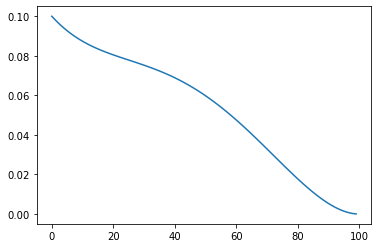

In [60]:
#negative exponential bets are not necessarily convex unless a = 1
a = 1
b = 1
etas = np.arange(0,1,.01)
x = np.ones(10) * 0.5
mart = []
for eta in etas:
    eta_1 = eta
    eta_2 = 1 - eta
    mart.append((1 + np.exp(a - b * eta_1) * (0 - eta_1)) * (1 + np.exp(a - b * eta_2) * (0.1 - eta_2)))
plt.plot(np.array(mart))

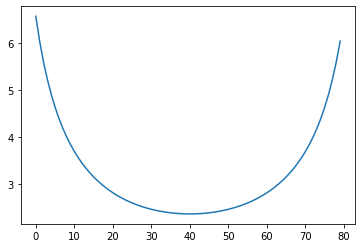

In [47]:
#inverse bets
c = 0.9
etas = np.arange(0.1,0.9,.01)
x = np.ones(10) * 0.5
mart = []
for eta in etas:
    eta_1 = eta
    eta_2 = 1 - eta
    mart.append((1 + (c/eta_1) * (0.8 - eta_1)) * (1 + (c/eta_2) * (0.8 - eta_2)))
plt.plot(np.array(mart))

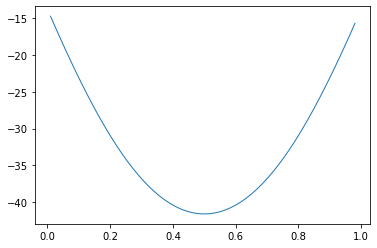

In [69]:
lam_func = Bets.negative_exponential
def lam_func(x, eta):
    return np.exp(1 - 2*eta)
allocation_func = Allocations.round_robin
mixing_dist = None
combine = "product"
theta_func = None
log = True

N = [30,30]
x = [np.random.normal(0.5, 0.1, N[0]), np.random.normal(0.5, 0.1, N[0])]
x = [np.ones(N[0]) * 0, np.ones(N[0]) * 0]

eta_grid = np.arange(range[0] + res, range[1]-res, step=res)
eta_xs, eta_ys, eta_zs, objs = [], [], [], []
w = N / np.sum(N)
for eta_x in eta_grid:
    eta_y = (1/2 - w[0] * eta_x) / w[1]
    if eta_y > 1 or eta_x < 0: continue
    obj = intersection_mart(x = x, N = N, eta = np.array([eta_x,eta_y]), lam_func = lam_func,
     lam = None, mixing_dist = mixing_dist, allocation_func = allocation_func,
     combine = combine, theta_func = theta_func, log = log, running_max = False)[-1]
    eta_xs.append(eta_x)
    eta_ys.append(eta_y)
    objs.append(obj)
min_ix = np.argmin(objs)
min_eta = np.round([eta_xs[min_ix], eta_ys[min_ix]], 2)
plt.plot(eta_xs, objs, linewidth = 1)
plt.show()

In [3]:
x = np.array([0,1,0.5,0.6, 0.6, 0.6, 0.6])
sd_min = 0.01
c = 0.9
eta = 0.5
eps = 1e-5
w = Welford()
mu_hat = []
sd_hat = []
for x_i in x:
    w.add(x_i)
    mu_hat.append(float(w.mean))
    sd_hat.append(np.sqrt(w.var_s))
sd_hat[0] = 1/4
lag_mu_hat = np.insert(mu_hat, 0, 1/2)[0:-1]
lag_sd_hat = np.insert(np.maximum(sd_hat, sd_min), 0, 1/4)[0:-1]

lam_untrunc = (lag_mu_hat - eta) / (lag_sd_hat**2 + (lag_mu_hat - eta)**2)
#this rule says to bet the farm when eta is 0 (can't possibly lose)
lam_trunc = np.maximum(0, np.where(eta > 0, np.minimum(lam_untrunc, c/(eta+eps)), np.inf))

In [58]:
K = 2
w = [1/2, 1/2]
N = np.array([500, 500])
eta_0 = 1/2
eta_bands = construct_eta_bands(eta_0, N = w, n_bands = 100)
global_mean = 0.65
#deltas = [0.25, -0.25]
deltas = [0, 0]
sd = 0.05
x = [np.random.binomial(1, global_mean + deltas[k], N[k]) for k in range(K)]

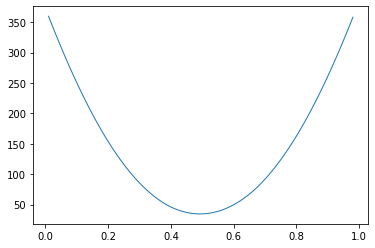

minimum eta = [0.49 0.51]
minimum = 34.69900040249988
stopping time = 120


In [59]:
lam = lambda x, eta: Bets.negative_exponential(x, eta, c = 1)
ui_mart, min_etas, global_ss = banded_uits(
                            x = x,
                            N = N,
                            etas = eta_bands,
                            lam_func = lam,
                            allocation_func = Allocations.round_robin,
                            log = True,
                            WOR = False)
#eps = lambda x, eta: Bets.negative_exponential(x, eta, c = )
#lam = lambda x, eta: Bets.inverse_eta(x, eta, c = 0.5)
plot_marts_eta(x, N, lam_func = lam, log = True)
print("stopping time = " + str(np.argmax(ui_mart > np.log(1/0.05))))

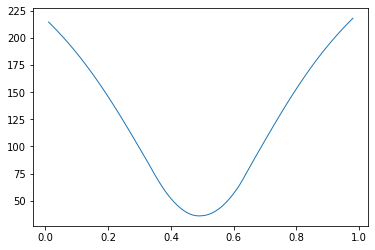

minimum eta = [0.49 0.51]
minimum = 35.99008036533107
stopping time = 148


In [60]:
lam = lambda x, eta: Bets.agrapa(x, eta) 
ui_mart, min_etas, global_ss = banded_uits(
                            x = x,
                            N = N,
                            etas = eta_bands,
                            lam_func = lam,
                            allocation_func = Allocations.round_robin,
                            log = True,
                            WOR = False)
plot_marts_eta(x, N, lam_func = lam, log = True)
print("stopping time = " + str(np.argmax(ui_mart > np.log(1/0.05))))

In [172]:
%%time
rep_grid = np.arange(1) #allows reps within parallelized simulations
sim_id = str(2)
np.random.seed(int(sim_id)) #this sets a different seed for every rep


#alt_grid = np.linspace(0.51, 0.7, 20)
alt_grid = [0.65]
delta_grid = [0.5]
alpha = 0.05
eta_0 = 0.5

methods_list = ['uinnsm_product','lcb']
bets_dict = {
    "fixed_plugin": Bets.predictable_plugin,
    "agrapa":lambda x, eta: Bets.agrapa(x, eta, c = 0.75),
    "bernoulli":lambda x, eta: Bets.predictable_bernoulli(x, eta, c = 0.75),
    "smooth_predictable":lambda x, eta: Bets.negative_exponential(x, eta, c = 0.95)}
bets_list = ["smooth_predictable"]
allocations_dict = {
    "round_robin":Allocations.round_robin,
    "predictable_kelly":Allocations.predictable_kelly,
    "greedy_kelly":Allocations.greedy_kelly}
#allocations_list = ["round_robin", "predictable_kelly", "greedy_kelly"]
allocations_list = ["round_robin"]

K = 2
w = [1/2, 1/2]
N = np.array([100, 100]) #size of initial sample
N_next = np.array([200, 200]) #size of blocks at which sample will expand
N_max = np.array([2100, 2100]) #maximum size
results = []
eta_bands = construct_eta_bands(eta_0, N = w, n_bands = 100)

for alt, delta, rep in itertools.product(alt_grid, delta_grid, rep_grid):
    print(str(alt))
    sim_rep = sim_id + "_" + str(rep)
    means = [alt - 0.5*delta, alt + 0.5*delta]
    samples = [np.random.binomial(1, means[k], N[k]) for k in range(K)]
    #ap bernoulli is based on the true means
    bets_dict["apriori_bernoulli"] = [
        lambda x, eta: Bets.apriori_bernoulli(x, eta, mu_0 = means[0]),
        lambda x, eta: Bets.apriori_bernoulli(x, eta, mu_0 = means[1])]
    for method, bet, allocation in itertools.product(methods_list, bets_list, allocations_list):
        if method == 'lcb':
            min_eta = None
            if allocation in ['proportional_to_mart','predictable_kelly','greedy_kelly']:
                stopping_time = None
                sample_size = None
            else:
                done = False
                while not done:
                    lower_bound = global_lower_bound(
                        x = samples,
                        N = N,
                        lam_func = bets_dict[bet],
                        allocation_func = allocations_dict[allocation],
                        alpha = alpha,
                        breaks = 1000,
                        WOR = False)
                    if any(lower_bound > eta_0):
                        sample_size = stopping_time = np.argmax(lower_bound > eta_0)
                        done = True
                    elif any(N >= N_max):
                        sample_size = stopping_time = np.sum(N)-1
                        done = True
                    else:
                        for k in range(K):
                            samples[k] = np.append(samples[k], np.random.binomial(1, means[k], N_next[k]))
                        N = N + N_next
        elif method == 'uinnsm_product':
            done = False
            while not done:
                ui_mart, min_etas, global_ss = banded_uits(
                            x = samples,
                            N = N,
                            etas = eta_bands,
                            lam_func = bets_dict[bet],
                            allocation_func = allocations_dict[allocation],
                            log = True,
                            WOR = False)
                if any(ui_mart > np.log(1/alpha)):
                    stopping_time = np.argmax(ui_mart > np.log(1/alpha))
                    min_eta = min_etas[stopping_time]
                    sample_size = global_ss[stopping_time]
                    done = True
                elif any(N >= N_max):
                    stopping_time = np.sum(N)-1
                    min_eta = min_etas[stopping_time]
                    sample_size = global_ss[stopping_time]
                    done = True
                else:
                    for k in range(K):
                        samples[k] = np.append(samples[k], np.random.binomial(1, means[k], N_next[k]))
                    N = N + N_next
        data_dict = {
            "alt":alt,
            "rep":sim_rep,
            "delta":delta,
            "method":str(method),
            "bet":str(bet),
            "allocation":str(allocation),
            "stopping_time":stopping_time,
            "sample_size":sample_size,
            "worst_case_eta":min_eta}
        results.append(data_dict)
results = pd.DataFrame(results)

0.65


/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:231: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - np.log(eps)) / lag_mu_hat
/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:232: RuntimeWarning: invalid value encountered in multiply
  lam = np.exp(1 - b * eta)


CPU times: user 2.92 s, sys: 19.1 ms, total: 2.94 s
Wall time: 2.93 s


In [173]:
res = banded_uits(x = samples,
                    N = N,
                    etas = eta_bands,
                    lam_func = bets_dict[bet],
                    allocation_func = allocations_dict[allocation],
                    log = True,
                    WOR = False, verbose = True)

/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:231: RuntimeWarning: divide by zero encountered in true_divide
  b = (1 - np.log(eps)) / lag_mu_hat


In [174]:
obj = res[3]

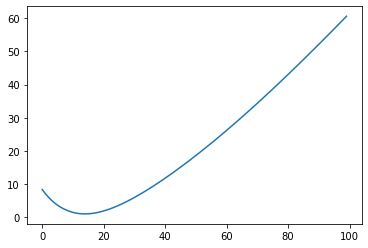

In [176]:
plt.plot(obj[:,100])

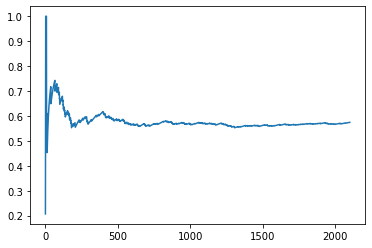

In [86]:
plt.plot(res[5][0][1])

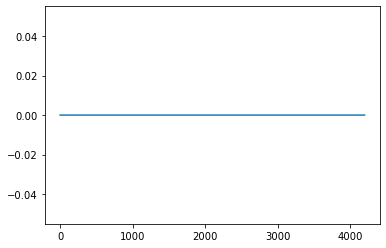

In [81]:
plt.plot(obj[0,:])

In [91]:
res[5][0]

[array([2.64916993, 0.        , 0.        , ..., 2.59999033, 2.60007227,
        2.60015402]),
 array([0.20693219, 0.75      , 1.        , ..., 0.57410045, 0.57421668,
        0.57433282])]

In [155]:
eta_bands[0]

[(array([0., 1.]), array([0.01, 0.99])), array([0.005, 0.995])]

In [156]:
etas = eta_bands
i = 0
lam_func = [bets_dict["smooth_predictable"], bets_dict["smooth_predictable"]]
log = True
ws_N = np.inf * np.ones(2)
N = N_max
bets = []
x = samples
allocation_func = Allocations.round_robin
n = [x_k.shape[0] for x_k in x]
WOR = False
obj = np.zeros((len(etas), np.sum(n) + 1))
sel = np.zeros((len(etas), np.sum(n) + 1, K))
min_etas = []
bets = []


centroid_eta = etas[i][1]
max_eta = np.max(np.vstack(etas[i][0]),0) #record largest eta in the band for each stratum
#bets are determined for max_eta, which makes the bets conservative for both strata and both vertices of the band
bets_i = [mart(x[k], max_eta[k], lam_func[k], None, ws_N[k], log, output = "bets") for k in np.arange(K)]
bets.append(bets_i)
#selections are determined by the centroid
T_k_i = selector(x, N, allocation_func, centroid_eta, bets_i)
itsm_mat = np.zeros((np.sum(n)+1, 2))
#minima are evaluated at the endpoints of the band//
#one of which is the minimum over the whole band due to concavity
for j in np.arange(2):
    itsm_mat[:,j] = intersection_mart(x = x, N = N, eta = etas[i][0][j], lam = bets_i, T_k = T_k_i,
        combine = "product", log = log, WOR = WOR)
obj[i,:] = np.min(itsm_mat, 1)
sel[i,:,:] = T_k_i

In [157]:
bets_i

[array([2.64916993, 0.        , 0.        , ..., 2.59999033, 2.60007227,
        2.60015402]),
 array([0.20693219, 0.75      , 1.        , ..., 0.57410045, 0.57421668,
        0.57433282])]

In [158]:
intersection_mart(x = x, N = N, eta = etas[i][0][0], lam = bets_i, T_k = T_k_i,
        combine = "product", log = log, WOR = WOR)

array([0., 0., 0., ..., 0., 0., 0.])

In [159]:
eta = etas[i][0][0]
lam = bets_i
T_k = T_k_i
ws_log = True
last = False

if lam is None:
    lam = [mart(x[k], eta[k], lam_func[k], None, ws_N[k], ws_log, output = "bets") for k in np.arange(K)]
#within-stratum martingales
ws_marts = [mart(x[k], eta[k], None, lam[k], ws_N[k], ws_log) for k in np.arange(K)]
#construct the interleaving
if T_k is None:
    T_k = selector(x, N, allocation_func, eta, lam)
if last:
    marts = np.array([[ws_marts[k][T_k[-1, k]] for k in np.arange(K)]])
    if np.any(np.isposinf(marts)):
        #it's not exactly clear how to handle certainties when sampling without replacement
        #i.e. what if the null is certainly false in one stratum but certainly true in another...
        marts = np.inf * np.ones((1,K))
else:
    marts = np.zeros((T_k.shape[0], K))
    for i in np.arange(T_k.shape[0]):
        marts_i = np.array([ws_marts[k][T_k[i, k]] for k in np.arange(K)])
        #make all marts infinite if one is, when product is taken this enforces rule:
        #we reject intersection null if certainly False in one stratum
        #TODO: rethink this logic? What if the null is certainly true in a stratum?
        #there is some serious subtlety to be considered when sampling WOR
        marts[i,:] = marts_i if not any(np.isposinf(marts_i)) else np.inf * np.ones(K)

In [171]:
bets_i[1][0:30]

array([0.20693219, 0.75      , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.52653086, 0.55925583,
       0.58656122, 0.60974163, 0.45308296, 0.47793199, 0.50004028,
       0.51984731, 0.53770502, 0.55389774, 0.56865717, 0.58217386,
       0.59460579, 0.60608501, 0.61672272, 0.62661323, 0.63583705,
       0.6444633 , 0.65255171, 0.66015414, 0.66731586, 0.67407655])

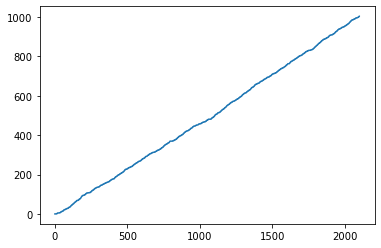

In [141]:
plt.plot(mart(x[0], eta[0], None, lam[0], ws_N[0], ws_log))

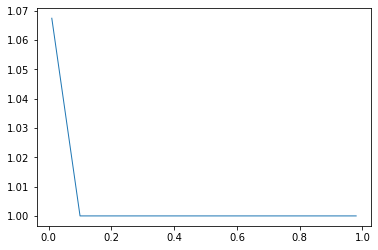

minimum eta = [0.1 0.9]
minimum = 1.0


In [23]:
N = [20, 20]
x = [0.1 * np.ones(N[0]), 0.5 * np.ones(N[1])]
#lam = lambda x, eta: Bets.negative_exponential(x, eta, a = 1, b = 1)
lam = lambda x, eta: Bets.fixed(x, eta)
plot_marts_eta(x, N, lam_func = lam, log = False)

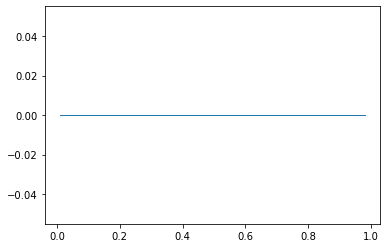

In [11]:
lam_func = lam
allocation_func = Allocations.round_robin
mixing_dist = None
combine = "product"
theta_func = None
res = 0.01
range = [0,1]
log = True

eta_grid = np.arange(range[0] + res, range[1]-res, step=res)
eta_xs, eta_ys, eta_zs, objs = [], [], [], []
w = N / np.sum(N)
for eta_x in eta_grid:
    eta_y = (1/2 - w[0] * eta_x) / w[1]
    if eta_y > 1 or eta_x < 0: continue
    obj = intersection_mart(x = x, N = N, eta = np.array([eta_x,eta_y]), lam_func = lam_func,
     lam = None, mixing_dist = mixing_dist, allocation_func = allocation_func,
     combine = combine, theta_func = theta_func, log = log)[-1]
    eta_xs.append(eta_x)
    eta_ys.append(eta_y)
    objs.append(obj)
min_ix = np.argmin(objs)
min_eta = np.round([eta_xs[min_ix], eta_ys[min_ix]], 2)
plt.plot(eta_xs, objs, linewidth = 1)
plt.show()

In [13]:
eta_y

0.020000000000000018